# Лабораторная работа 3: Анализ и моделирование одномерных случайных величин
_Команда 10_ <br>
_Сурнаков, Ковалев, Нетроголов, Тюрин_

## 1 Представление набора данных

### Библиотеки

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats, optimize
from scipy.stats import shapiro, levene, goodness_of_fit
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

np.random.seed(seed=42)

### Чтение данных

In [ ]:
URL = "https://courses.openedu.ru/assets/courseware/v1/fed9823d73d2b53f5591d98b87c20b8a/asset-v1:ITMOUniversity+ADVMLDEEPLEARN+fall_2023_ITMO_mag+type@asset+block/fish_train.csv"

data = pd.read_csv(URL)
data

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Roach,150.0,20.4,22.0,24.7,5.8045,3.7544
1,Perch,250.0,25.4,27.5,28.9,7.2828,4.5662
2,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
3,Bream,925.0,36.2,39.5,45.3,18.7542,6.7497
4,Perch,110.0,19.0,21.0,22.5,5.6925,3.5550
...,...,...,...,...,...,...,...
114,Parkki,273.0,23.0,25.0,28.0,11.0880,4.1440
115,Pike,500.0,42.0,45.0,48.0,6.9600,4.8960
116,Whitefish,1000.0,37.3,40.0,43.5,12.3540,6.5250
117,Perch,120.0,20.0,22.0,23.5,6.1100,3.4075


In [ ]:
data.Species.nunique()

7

In [ ]:
data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,405.177311,26.594958,28.781513,31.602521,9.092096,4.507407
std,338.834252,9.613002,10.308208,11.116086,4.231866,1.678796
min,0.000000,7.500000,8.400000,8.800000,1.738800,1.047600
25%,142.500000,20.000000,22.000000,23.500000,6.138850,3.536400
50%,300.000000,25.400000,27.500000,30.600000,8.145400,4.335000
75%,685.000000,33.850000,36.450000,40.150000,12.143400,5.789550
max,1550.000000,56.000000,60.000000,64.000000,18.957000,8.142000


Есть нулевое значение признака Weight, что является невозможным с точки зрения физики. Заменим его на среднее значение выборки по данному признаку

In [ ]:
data = data.drop(['Length2', 'Length3'], axis=1).rename({'Length1': 'Length'}, axis=1)
print(data.Weight[15])
data.Weight[15] = data.Weight.mean()
data.Weight.nunique()

0.0


<ipython-input-5-22ee4122d2d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Weight[15] = data.Weight.mean()


81

В качестве подвыборки для анализа данных был выбран следующий датасет:

In [ ]:
print(data.head())
print(data.shape)

  Species  Weight  Length   Height   Width
0   Roach   150.0    20.4   5.8045  3.7544
1   Perch   250.0    25.4   7.2828  4.5662
2   Bream   430.0    26.5  12.4440  5.1340
3   Bream   925.0    36.2  18.7542  6.7497
4   Perch   110.0    19.0   5.6925  3.5550
(119, 5)


Признак Species, являясь категориальным, распределен как дискретная случайная величина.

In [ ]:
print(f"Species может принимать 7 значений: {list(data.Species.unique())}.")

Species может принимать 7 значений: ['Roach', 'Perch', 'Bream', 'Whitefish', 'Smelt', 'Parkki', 'Pike'].


In [ ]:
le = LabelEncoder()
le.fit(list(data.Species.unique()))
data.Species = le.transform(list(data.Species))

<Axes: ylabel='Species'>

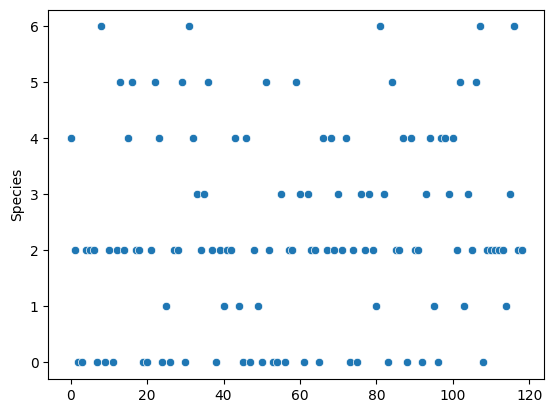

In [ ]:
sns.scatterplot(data.Species)

Weight, Length, Height и Width - непрерывные случайные величины.

In [ ]:
data.describe()

,Species,Weight,Length,Height,Width
count,119.000000,119.000000,119.000000,119.000000,119.000000
mean,2.277311,408.582162,26.594958,9.092096,4.507407
std,1.711993,336.757627,9.613002,4.231866,1.678796
min,0.000000,5.900000,7.500000,1.738800,1.047600
25%,1.000000,145.000000,20.000000,6.138850,3.536400
50%,2.000000,300.000000,25.400000,8.145400,4.335000
75%,3.500000,685.000000,33.850000,12.143400,5.789550
max,6.000000,1550.000000,56.000000,18.957000,8.142000


<Axes: >

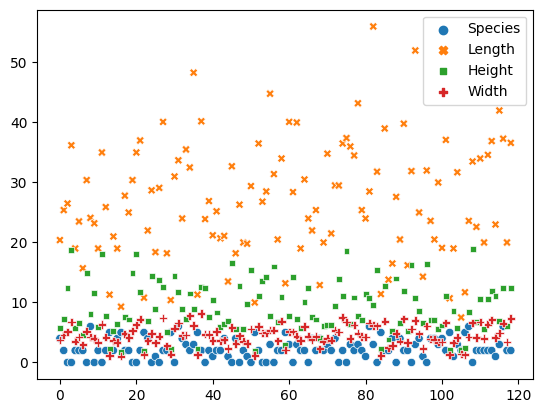

In [ ]:
sns.scatterplot(data.drop(['Weight'], axis=1))

<Axes: ylabel='Weight'>

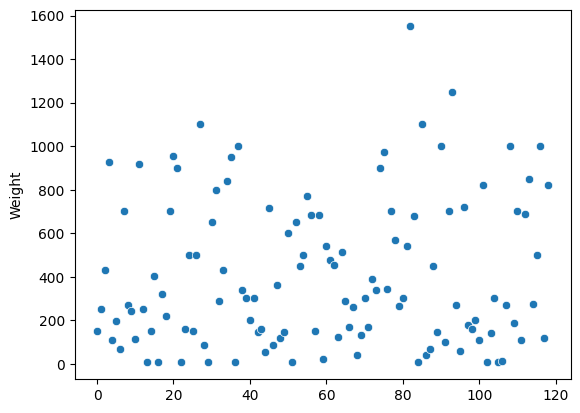

In [ ]:
sns.scatterplot(data['Weight'])

## 2 Непараметрическая оценка плотности распределения в виде гистограммы и используя функцию плотности ядра / закона вероятности

In [ ]:
data.head()

,Species,Weight,Length,Height,Width
0,4,150.0,20.4,5.8045,3.7544
1,2,250.0,25.4,7.2828,4.5662
2,0,430.0,26.5,12.4440,5.1340
3,0,925.0,36.2,18.7542,6.7497
4,2,110.0,19.0,5.6925,3.5550


### Непрерывные случайные величины

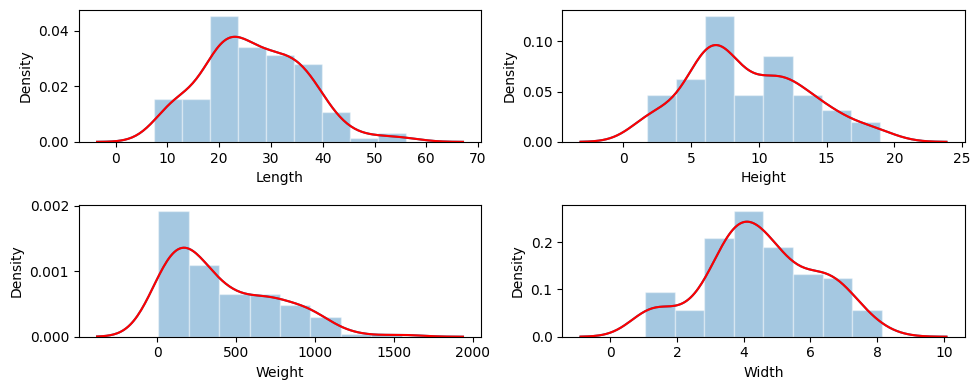

In [ ]:
#Plotting a histogram and kernel density estimate
fig, axes = plt.subplots(2,2, figsize=(10,4))

# Get plots
sns.histplot(data.Length, kde=True, stat="density", kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=axes[0,0])
sns.kdeplot(data.Length, color='r', fill=False, ax=axes[0,0])

sns.histplot(data.Height, kde=True, stat="density", kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=axes[0,1])
sns.kdeplot(data.Height, color='r', ax=axes[0,1])

sns.histplot(data.Weight, kde=True, stat="density", kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=axes[1,0])
sns.kdeplot(data.Weight, color='r', ax=axes[1,0])

sns.histplot(data.Width, kde=True, stat="density", kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=axes[1,1])
sns.kdeplot(data.Width, color='r', ax=axes[1,1])

plt.tight_layout()
plt.show()

### Дискретная случайная величина

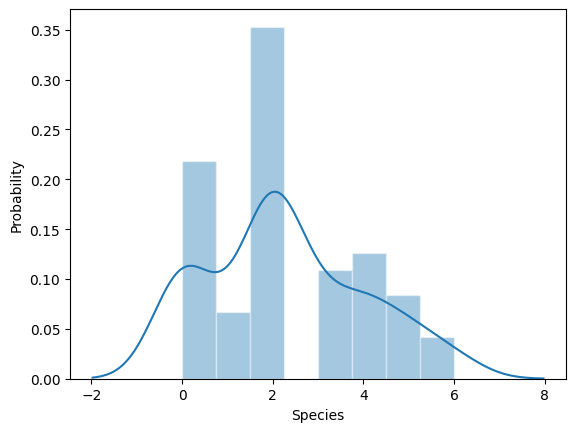

In [ ]:
#Plotting a histogram and kernel density estimate
sns.histplot(data.Species, kde=True, stat="probability", kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4))
x_scatter = np.linspace(data.Species.min(), data.Species.max())


## 3 Оценка порядковых статистик и представление их в виде "ящиков с усами"

### Непрерывные случайные величины

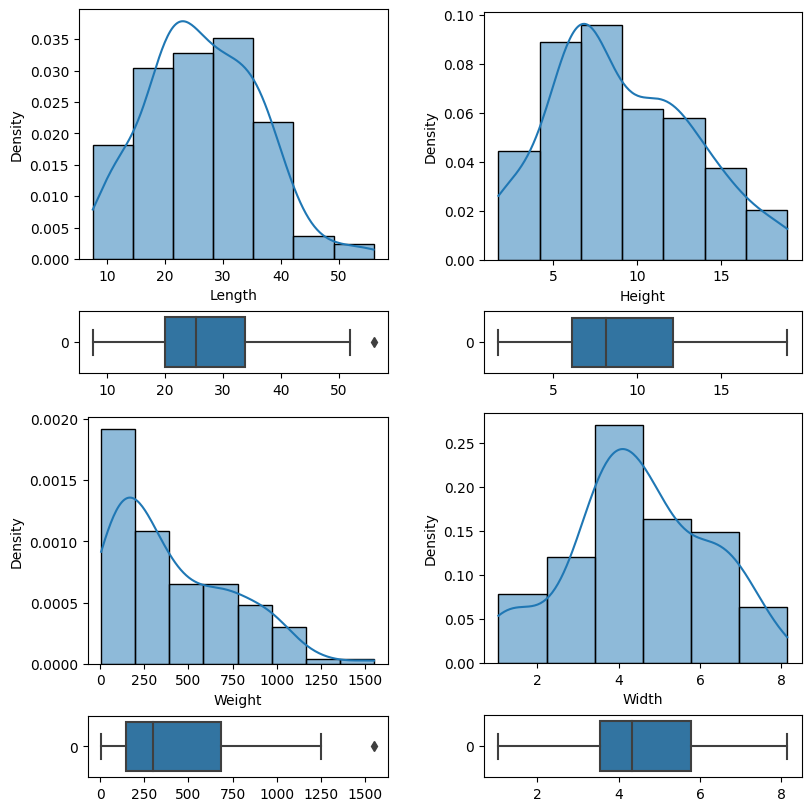

In [ ]:
fig = plt.figure(figsize=(8,8), layout="constrained")
subfigs = fig.subfigures(2, 2, wspace=0.07)

axes00 = subfigs[0,0].subplots(2,1, gridspec_kw={'height_ratios': [4,1]})
sns.histplot(data.Length, kde=True, bins=7, stat='density', ax=axes00[0])
sns.boxplot(data.Length, orient='h', ax=axes00[1])

axes01 = subfigs[0,1].subplots(2,1, gridspec_kw={'height_ratios': [4,1]})
sns.histplot(data.Height, kde=True, bins=7, stat='density', ax=axes01[0])
sns.boxplot(data.Height, orient='h', ax=axes01[1])

axes10 = subfigs[1,0].subplots(2,1, gridspec_kw={'height_ratios': [4,1]})
sns.histplot(data.Weight, kde=True, bins=8, stat='density', ax=axes10[0])
sns.boxplot(data.Weight, orient='h', ax=axes10[1])

axes11 = subfigs[1,1].subplots(2,1, gridspec_kw={'height_ratios': [4,1]})
sns.histplot(data.Width, kde=True, bins=6, stat='density', ax=axes11[0])
sns.boxplot(data.Width, orient='h', ax=axes11[1])

plt.show()

In [ ]:
data[['Length', 'Height', 'Weight', 'Width']].describe()

,Length,Height,Weight,Width
count,119.000000,119.000000,119.000000,119.000000
mean,26.594958,9.092096,408.582162,4.507407
std,9.613002,4.231866,336.757627,1.678796
min,7.500000,1.738800,5.900000,1.047600
25%,20.000000,6.138850,145.000000,3.536400
50%,25.400000,8.145400,300.000000,4.335000
75%,33.850000,12.143400,685.000000,5.789550
max,56.000000,18.957000,1550.000000,8.142000


Видно, что распределения *'Length'*, *'Height'* и *'Width'* вцелом не обладают какими-то ярковыраженными смещениями к минимуму или максимуму. Чего нельзя сказать о распределении признака *'Weight'*, среднее которого сильно смещено влево.

Большого количества выбросов в данных не наблюдается.

Оценим робастные значения усеченных средних:

In [ ]:
trim_df = pd.DataFrame(index=['mean', 'trim_mean', 'min', 'q5', 'max', 'q95'])
for label in ['Length', 'Height', 'Weight', 'Width']:
    mean = round(data[label].mean(), 2)
    min = round(data[label].min(), 2)
    max = round(data[label].max(), 2)
    trim_mean = round(stats.trim_mean(data[label], .05),2)
    q5, q95 = (round(np.quantile(data[label],.05),2), round(np.quantile(data[label],.95),2))
    trim_df[label] = [mean, trim_mean, min, q5, max, q95]

trim_df

,Length,Height,Weight,Width
mean,26.59,9.09,408.58,4.51
trim_mean,26.35,8.99,390.67,4.52
min,7.50,1.74,5.90,1.05
q5,11.25,2.20,9.80,1.28
max,56.00,18.96,1550.00,8.14
q95,40.38,16.38,1000.00,7.23


Видно, что особенно больше отличие среднего по всей выборке и усеченного среднего наблюдается у случайной величины Weight.
Минимальные и максимальные значения по сравнению с 5-ым и 95-ым квантилями наиболее значительно отличаются у случайных величин Length и Weight.


### Дискретные случайные величины

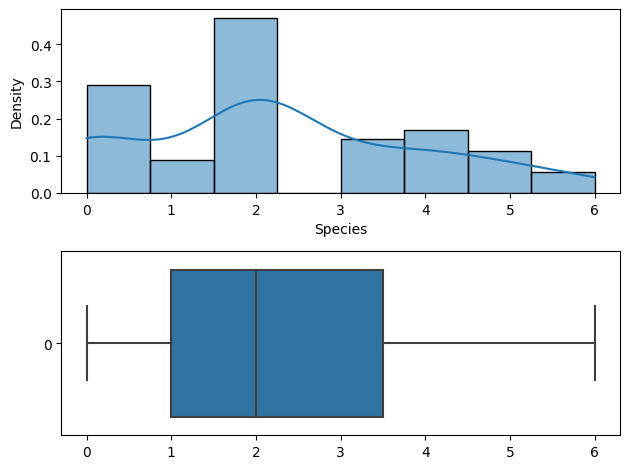

In [ ]:
fig, axes = plt.subplots(2,1)

sns.histplot(data.Species, kde=True, stat='density', ax=axes[0])
sns.boxplot(data.Species, orient='h', ax=axes[1])

plt.tight_layout()

In [ ]:
data['Species'].describe()

count    119.000000
mean       2.277311
std        1.711993
min        0.000000
25%        1.000000
50%        2.000000
75%        3.500000
max        6.000000
Name: Species, dtype: float64

In [ ]:
print(f"Мода для Species: {data.Species.mode()[0]} ({len(data.Species.loc[data.Species==2])} из {len(data)})")

Мода для Species: 2 (42 из 119)


## 4 Теоретические распределения, описывающие выборку

### Непрерывные случайные величины

Исходя из графиков распределений можно предположить, что для описания непрерывных случайных величин *Length, Height и Width* подходит теоретическое **распределение Гаусса**.

![gauss](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Normal_distribution_pdf.png/650px-Normal_distribution_pdf.png)



Попробуем **при помощи метода моментов** оценить внешне, на сколько выбранный тип распределений повторяет наши данные:

In [ ]:
def plot_norm_dist(data, ax=None, color='r'):
    # Parameters of the normal distribution
    mu = stats.trim_mean(data, .05) # take trimmed mean
    sigma = np.sqrt(data.var())

    # Generating random variable values
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, len(data))
    y = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))

    # Plotting
    if ax:
        ax.plot(x, y, color)
        ax.annotate(f"MM:\nmu = {mu:.3f}\nsigma = {sigma:.3f}", xy=(0, 0.8*y.max()))

    return x, y, mu, sigma

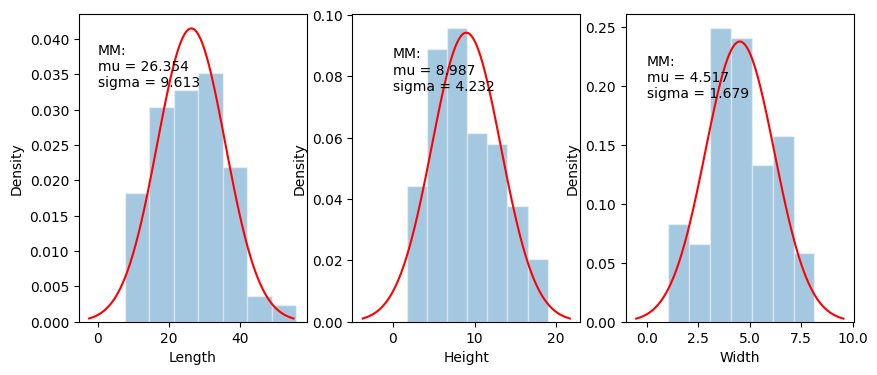

In [ ]:
# Plotting the histograms and the theoretical distributions of random variables
fig, axes = plt.subplots(1,3, figsize=(10,4))

for i, dt in enumerate([data.Length, data.Height, data.Width]):
    # Get plots
    sns.histplot(dt, kde=False, stat="density", bins=7, kde_kws=dict(cut=3),
                 alpha=.4, edgecolor=(1, 1, 1, .4), ax=axes[i])
    _, _, _, _ = plot_norm_dist(dt, ax=axes[i])

На первый взгляд кажется, что нормальное распределение довольно неплохо описывает наши данные.



---


Для непрерывной случайной величины *Weight* было выбрано наиболее подходящим **Логнормальное распределение**:

<!-- <div style="font-size: 150%;">   -->
$$x \sim \text{logN}(\mu, \sigma^2)$$
<!-- </div> -->

![logN](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Lognormal_distribution_PDF.png/650px-Lognormal_distribution_PDF.png)


Оценим **при помощи метода моментов** внешне, на сколько выбранный тип распределений повторяет наши данные:

In [ ]:
def plot_logN_dist(data, ax=None, color='b'):
    # Parameters of the lognormal distribution
    mu = stats.trim_mean(np.log(data), .05) # take trimmed mean
    sigma = np.std(np.log(data))

    # Generating random variable values
    x = np.linspace(0, data.max(), int(data.max()))
    y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))

    # Plotting
    if ax:
        ax.plot(x, y, color)
        ax.annotate(f"MM:\nmu = {mu:.3f}\nsigma = {sigma:.3f}", xy=(np.mean(x), 0.002))

    return x, y, mu, sigma

<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: divide by zero encountered in divide
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: divide by zero encountered in log
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: invalid value encountered in multiply
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))


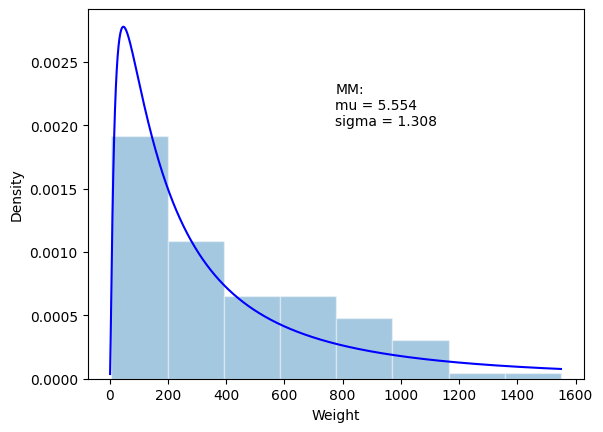

In [ ]:
fig, ax = plt.subplots(1,1)

sns.histplot(data.Weight, stat="density",
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
_,_,_,_ = plot_logN_dist(data.Weight, ax=ax)

Вцелом тоже похоже на первый взгляд, но уже кажется не так хорошо, как могло бы быть

### Дискретная случайная величина

Для дискретной величины *Species* скорее всего подойдет ***распределение Пуассона***:

![poisson](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Poisson_distribution_PMF.png/548px-Poisson_distribution_PMF.png)


In [ ]:
def plot_poisson_dist(data, ax=None, color='b', label=None):
    # Parameters of the lognormal distribution
    mu = np.mean(data) # take mean

    # Generating random variable values
    x = range(len(data))
    y = stats.poisson.pmf(x, mu)

    # Plotting
    if ax:
        ax.plot(x, y, color, label=label)
        ax.annotate(f"MM:\nmu = {mu:.5f}", xy=(mu, y.max()))

    return x, y, mu

(0.0, 6.0)

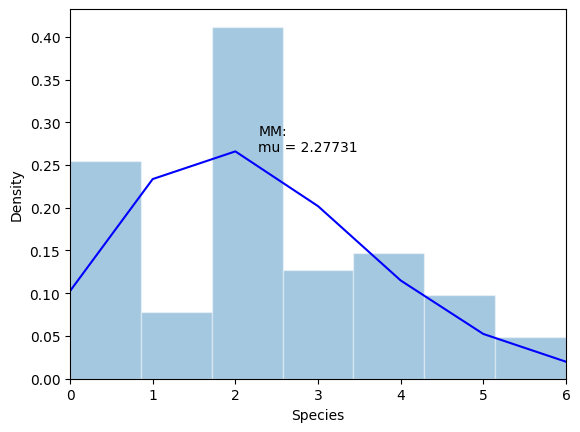

In [ ]:
fig, ax = plt.subplots(1,1)

sns.histplot(data.Species, bins=7, stat="density",
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
x,y,mu = plot_poisson_dist(data['Species'], ax=ax)
ax.set_xlim(0,6)

## 5 Оценка параметров выбранных распределений, с помощью метода максимального правдоподобия и метода наименьших квадратов

### Maximum Likelihood

#### Непрерывные случайные величины

In [ ]:
def plot_norm_MLE(data, ax=None, color='r', label=None):
    # Get parameters of the distribution
    loc, scale = stats.norm.fit(data, method='MLE')

    # Generating random variable values
    x = np.linspace(loc - 3*scale, loc + 3*scale, len(data))
    y = stats.norm.pdf(x, loc, scale)

    # Plotting
    if ax:
        ax.plot(x, y, color, label=label)
        ax.annotate(f"MLE:\nmu = {loc:.3f}\nsigma = {scale:.3f}", xy=(0, 0.1*y.max()))

    return x, y, loc, scale

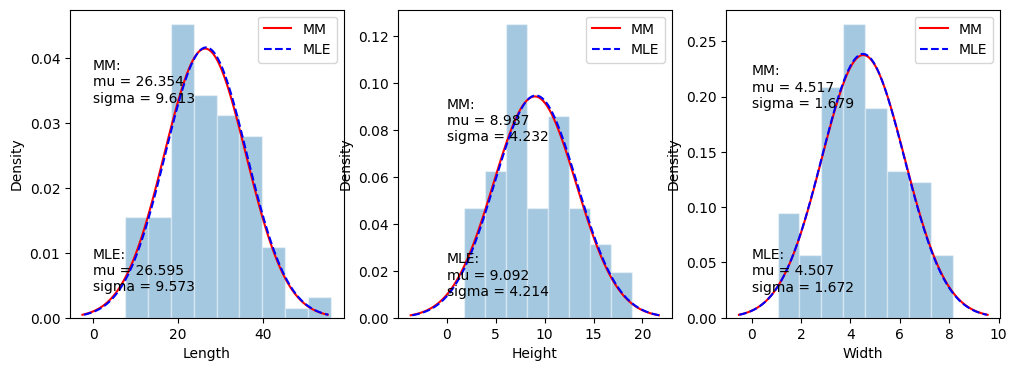

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

for i, dt, in enumerate([data.Length, data.Height, data.Width]):
    _, _,_,_ = plot_norm_dist(dt, axes[i])
    _, _,_,_ = plot_norm_MLE(dt, axes[i], color='b--')
    sns.histplot(dt, stat="density",
                 alpha=.4, edgecolor=(1, 1, 1, .4), ax=axes[i])
    axes[i].legend(['MM', 'MLE'])

В целом при помощи метода максимального правдоподобия (MLE) для трех случайных величин (*Length*, *Height*, *Width*) получены параметры распределений очень близкие к тем, что были рассчитаны при помощи простого метода моментов (MM). Отличия между значениями параметров минимальны.

Посмотрим на случайную величину *Weight*

In [ ]:
def plot_logN_MLE(data, ax=None, color='b', label=None):
    # Get parameters of the distribution
    shape, loc, scale = stats.lognorm.fit(data, method='MLE')

    # Generating random variable values
    x = np.linspace(0, data.max(), int(data.max()))
    y = stats.lognorm.pdf(x, shape, loc, scale)

    # Plotting
    if ax:
        ax.plot(x, y, color, label=label)
        ax.annotate(f"MLE:\nmu = {np.log(scale):.3f}\nsigma = {shape:.3f}", xy=(np.mean(x), 0.0015))

    return x, y, shape, loc, scale

<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: divide by zero encountered in divide
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: divide by zero encountered in log
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: invalid value encountered in multiply
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))


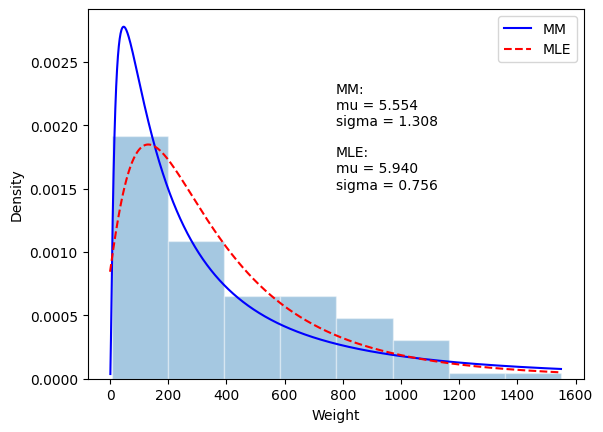

In [ ]:
ax = plt.subplot()

sns.histplot(data.Weight, stat="density",
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
_, _,_,_ = plot_logN_dist(data.Weight, ax)
_, _,_,_,_ = plot_logN_MLE(data.Weight, ax, color='r--')
ax.legend(['MM', 'MLE'])

Внешне кажется, что метод максимального правдоподобия позволяет подобрать параметры данного (логнормального) распределения для *Weight* лучше чем метод моментов.

#### Дискретная случайная величина

In [ ]:
def plot_poisson_MLE(data, ax=None, color='b', label=None):
    # Get parameters of the distribution
    mle_params = stats.fit(stats.poisson, data, bounds=[(0,7)], method='mle').params

    # Generating random variable values
    x = range(7)
    y = stats.poisson.pmf(x, *mle_params)

    # Plotting
    if ax:
        ax.plot(x, y, color, label=label)
        ax.annotate(f"MLE:\nmu = {mle_params[0]:.5f}", xy=(mle_params[0], y.mean()))

    return x, y, mle_params

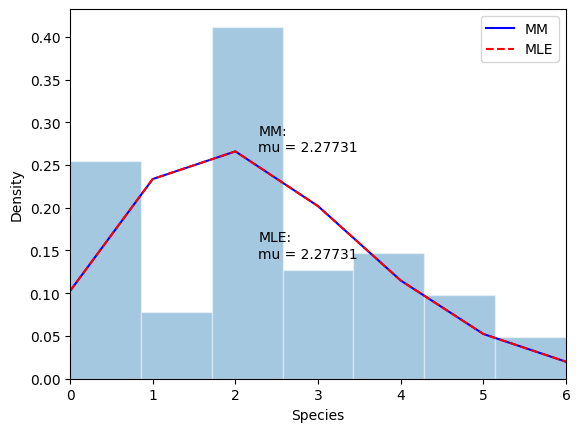

In [ ]:
fig, ax = plt.subplots(1,1)

sns.histplot(data.Species, bins=7, stat="density",
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
_,_,_ = plot_poisson_dist(data['Species'], ax=ax, label='MM')
_,_,_ = plot_poisson_MLE(data['Species'], ax=ax, label='MLE', color='r--')
ax.set_xlim(0,6)
ax.legend()

Метод максимального правдоподобия дал точно такое же приближение параметра mu, какое получается при его рассчете через метод моментов.

### МНК

Добавим к сравнению метод наименьших квадратов:

#### Непрерывные случайные величины

In [ ]:
def plot_norm_MLS(data, ax=None, color='m', optimizer='BFGS', label=None):
    # Get parameters of the distribution
    mu = stats.trim_mean(data, .05)
    sigma = np.sqrt(data.var())
    params = (mu, sigma)

    # Generating random variable values
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, len(data))
    y = np.histogram(data, bins=len(data), density=True)[0]

    # Optimizing parameters of distribution with method of least squares (MLS)
    def loss(params, x, y, distribution):
        # Get sum of (the difference between theoretical and actual distributions)**2
        return np.sum((y - distribution.pdf(x, *params))**2)

    result = optimize.minimize(loss, params, args=(x, y, stats.lognorm), method=optimizer)
    mu, sigma = result.x

    #Calculating random variable values
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, len(data))
    y = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))

    # Plotting
    if ax:
        ax.plot(x, y, color, label=label)
        ax.annotate(f"MLS:\nmu = {mu:.3f}\nsigma = {sigma:.3f}", xy=(mu, 0.3*y.max()))

    return x, y, mu, sigma

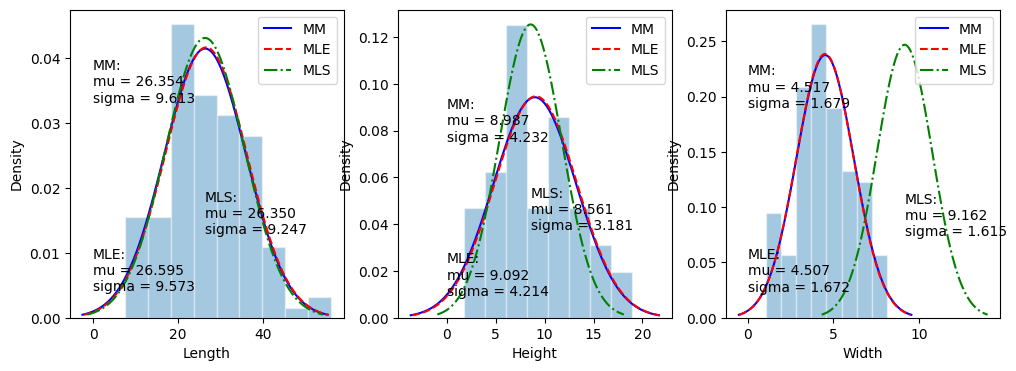

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

for i, dt in enumerate([data.Length, data.Height, data.Width]):
    sns.histplot(dt, stat="density",
                 alpha=.4, edgecolor=(1, 1, 1, .4), ax=axes[i])
    _, _,_,_ = plot_norm_dist(dt, axes[i], color='b')
    _, _,_,_ = plot_norm_MLE(dt, axes[i], color='r--')
    _, _,_,_ = plot_norm_MLS(dt, axes[i], color='g-.')
    axes[i].legend(['MM', 'MLE', 'MLS'])

Для *Length* результат довольно схож с тем, что был получен в результате использования метода максимального правдоподобия (MLE) в качестве метода приближения.

Для *Height* же параметры отличаются значительнее, особенное большое отличие получилось у параметров sigma.

В случае признака *Width* же МНК (MLS) сработал плохо (значение mu в ~2 раза больше ожидаемого) и сильно хуже результата приближения распределения при помощи MLE.
Возможно, дело в методе оптимизации, который был использован для подобора параметров распределения *mu* и *sigma*.

Попробуем для случайной величины *Width* применить другой метод оптимизации для МНК, например усеченный алгоритм Ньютона (truncated Newton algorithm (*TNC*)):

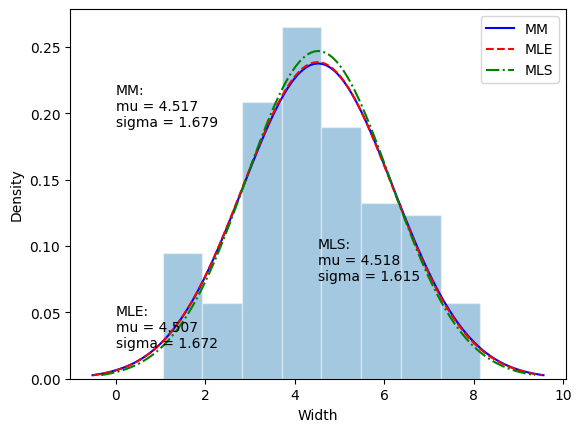

In [ ]:
ax = plt.subplot()

sns.histplot(data.Width, stat="density",
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
_, _,_,_ = plot_norm_dist(data.Width, ax, color='b')
_, _,_,_ = plot_norm_MLE(data.Width, ax, color='r--')
_, _,_,_ = plot_norm_MLS(data.Width, ax, color='g-.', optimizer='TNC')
ax.legend(['MM', 'MLE', 'MLS'])

Данный алгоритм оптимизации сработал намного лучше. Полученный для случайной величины *Width* при помощи МНК и оптимизатора TNC график распределения уже больше походит на распределение исходной выборки.

Однако до сих пор нельзя сказать точно, какие параметры дают наилучшие приближения теоретических распределний к исходным реальным данным.


---




In [ ]:
def plot_logN_MLS(data, ax=None, color='g', optimizer='BFGS'):
    # Get parameters of the distribution
    mu = stats.trim_mean(np.log(data), .05)
    sigma = np.std(np.log(data))
    params = (mu, sigma)

    # Generating random variable values
    x = np.linspace(0, data.max(), len(data))
    y = np.histogram(data, bins=len(data), density=True)[0]

    # Optimizing parametrs of distribution with method of least squares (MLS)
    def loss(params, x, y, distribution):
        # Get sum of (the difference between theoretical and actual distributions)**2
        return np.sum((y - distribution.pdf(x, *params))**2)

    result = optimize.minimize(loss, params, args=(x, y, stats.lognorm), method=optimizer)
    mu, sigma = result.x

    #Calculating random variable values
    y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))

    # Plotting
    if ax:
        ax.plot(x, y, color)
        ax.annotate(f"MLS:\nmu = {mu:.3f}\nsigma = {sigma:.3f}", xy=(np.mean(x), 0.001))
    return x, y, mu, sigma

<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: divide by zero encountered in divide
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: divide by zero encountered in log
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: invalid value encountered in multiply
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-37-0d768c792644>:20: RuntimeWarning: divide by zero encountered in divide
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-37-0d768c792644>:20: RuntimeWarning: divide by zero encountered in log
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-37-0d768c792644>:20: RuntimeWarning: invalid value en

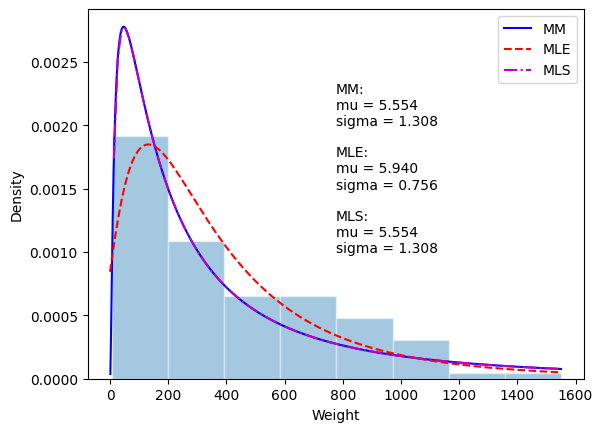

In [ ]:
ax = plt.subplot()

sns.histplot(data.Weight, stat="density",
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
_, _,_,_ = plot_logN_dist(data.Weight, ax)
_, _,_,_,_ = plot_logN_MLE(data.Weight, ax, color='r--')
_, _,_,_ = plot_logN_MLS(data.Weight, ax, color='m-.')
ax.legend(['MM', 'MLE', 'MLS'])

Внешне кажется, что метод максимального правдоподобия (MLE) в случае случайной величины *Weight* дает лучшее приближение распределения чем МНК (MLS). Параметры, рассчитанные при помощи МНК больше схожи с теми, что были получены при помощи метода моментов для данного логнормального распределения.

Однако, опять же, по графикам наверняка сказать какой из наборов параметров теоретических распределений описывает случайные величины лучше всего нельзя.

Необходимы дополнительные тесты и оценки распределений и их параметров.

#### Дискретная случайная величина

In [ ]:
def plot_poisson_MLS(data, ax=None, color='m', optimizer='TNC', label=None):
    # Get parameters of the distribution
    mu = np.mean(data)

    # Generating random variable values
    x = range(len(data))
    y = np.histogram(data, bins=len(data), density=True)[0]

    # Optimizing parameters of distribution with method of least squares (MLS)
    def loss(params, x, y, distribution):
        # Get sum of (the difference between theoretical and actual distributions)**2
        return np.sum((y - distribution.pmf(x, *params))**2)

    result = optimize.minimize(loss, (mu,), args=(x, y, stats.poisson), method=optimizer)
    mls_params = result.x

    #Calculating random variable values
    x = range(7)
    y = stats.poisson.pmf(x, *mls_params)

    # Plotting
    if ax:
        ax.plot(x, y, color, label=label)
        ax.annotate(f"MLS:\nmu = {mu:.5f}", xy=(mu, 0.2*y.max()))

    return x, y, mu

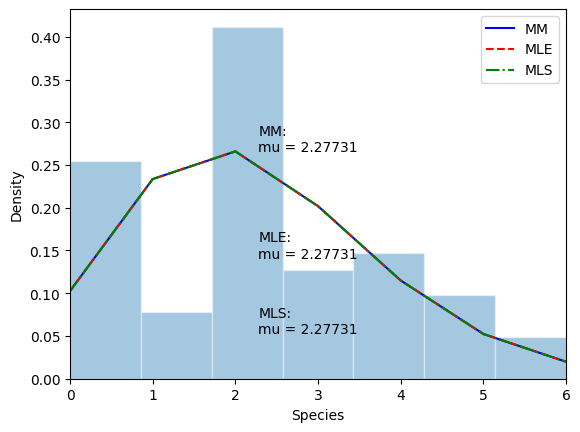

In [ ]:
fig, ax = plt.subplots(1,1)

sns.histplot(data.Species, bins=7, stat="density",
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
_,_,_ = plot_poisson_dist(data['Species'], ax=ax, label='MM')
_,_,_ = plot_poisson_MLE(data['Species'], ax=ax, label='MLE', color='r--')
_,_,_ = plot_poisson_MLS(data['Species'], ax=ax, label='MLS', color='g-.')
ax.set_xlim(0,6)
ax.legend()

Значение параметры mu снова идентично тем, что получены при помощи метода моментов и метода максимального правдоподобия.

## 6 Проверка оцененных параметров с помощью графика квантиль-квантиль (QQ)

#### Непрерывные случайные величины

Построим ***QQ-plot*** для случайных величины ***Length***, ***Height*** и ***Width***:

In [ ]:
def QQplot(dt, qn_first, qn_second, params, ax, logN=False, title='QQ-plot', method='method'):
    if logN:
        mu = np.log(params[2])
        sigma = params[0]
        x = np.linspace(0, dt.max(), int(dt.max()))
        ylabel = 'lognormal'
    else:
        mu = params[0]
        sigma = params[1]
        x = np.linspace(dt.min(), dt.max())
        ylabel = 'normal'

    # Bissectriss
    ax.plot(x, x, color="k", ls="--")

    # QQ-plot
    ax.scatter(qn_first, qn_second)
    ax.set_xlabel('Actual distr.')
    ax.set_ylabel(f'Theoretical ({ylabel}) distr.')
    ax.set_title(f'QQ-plot: {title}')
    ax.annotate(f"Method: {method}", xy=(dt.min(), dt.max()))

    # Calculation of the Kolmogorov-Smirnov test and chi-square
    if logN:
        ks = stats.kstest(dt, 'lognorm', params, N=len(dt))
    else:
        ks = stats.kstest(dt, 'norm', params, N=len(dt))
    ax.annotate(f"Kolm-Smirn:\nst: {ks[0]:.5f}\npv: {ks[1]:.5f}",
                                xy=(0.5*dt.max(), dt.min()))
    ax.annotate(f"mu = {mu:.5f}\nsigma = {sigma:.5f}",
                                xy=(dt.min(), 0.5*dt.max()))

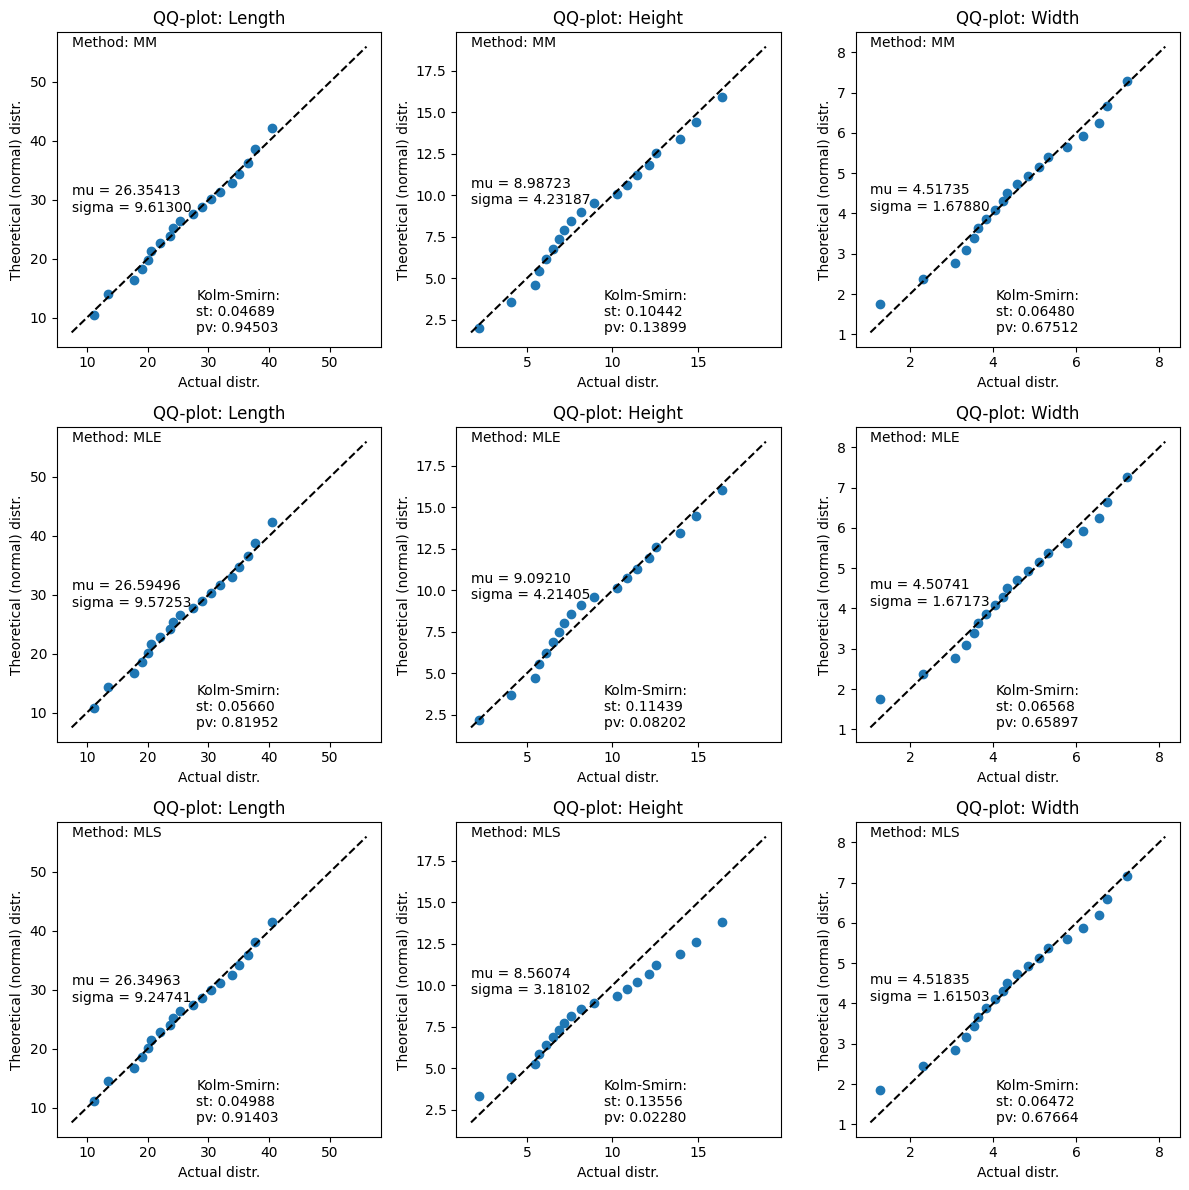

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(12,12))

percs = np.linspace(0, 100, 21) # percentiles

for n_col, dt in enumerate([data.Length, data.Height, data.Width]):
    qn_real_dist = np.percentile(dt, percs) # quantiles of the real values

    x_MM, y_MM, mu_MM, sigma_MM = plot_norm_dist(dt, ax=None) # norm distribution values (MM)
    x_MLE, y_MLE, mu_MLE, sigma_MLE = plot_norm_MLE(dt, ax=None) # norm distribution values (MLE)
    if n_col != 2:
        x_MLS, y_MLS, mu_MLS, sigma_MLS = plot_norm_MLS(dt, ax=None) # norm distribution values (MLS)
    else:
        x_MLS, y_MLS, mu_MLS, sigma_MLS = plot_norm_MLS(dt, ax=None, optimizer='TNC')

    ys = [y_MM, y_MLE, y_MLS]
    title = ['Length', 'Height', 'Width']
    method = ['MM', 'MLE', 'MLS']
    params = [(mu_MM, sigma_MM), (mu_MLE, sigma_MLE), (mu_MLS, sigma_MLS)]

    for n_row, y in enumerate(ys):
        # Quantiles of the assumed dist
        qn_norm_dist = stats.norm.ppf(percs / 100.0, *params[n_row])

        # QQ-plot
        QQplot(dt, qn_real_dist, qn_norm_dist, params[n_row], axes[n_row,n_col],
               logN=False, title=title[n_col], method=method[n_row])

plt.tight_layout()

На графиках изображены **квантильные биплоты** для трех случайных велимчин: ***Length***, ***Height*** и ***Width*** (столбцы сетки графиков). Для каждой случайной величины представлены графики для каждого из трех методов параметрической оценки распределений (строки сетки графиков):

*   *Метод Моментов (MM)*;
*   *Метод Максимального Правдоподобия (MLE)*;
*   *МНК (MLS)*.



Из построенных квантильных биплотов для случайных величин, распределенных, как мы предположили, в соответствии с ***нормальным*** распределением, видно, что большинство значений квантилей лежат на биссектриссе.

Это свидетельствует о том, что выбранное распределение с подобранными параметрами (mu и sigma) довольно неплохо описывает реальные данные.

Для всех вариантов методов подбора параметров распределений были проведены статистические тесты ***Колмагорова-Смирнова***. В результате были получены значения **оцененной статистики** (*st*) и **pvalue** (*pv*).

Сравнив полученные статистические параметры можно сделать вывод, что распределения каждой из трeх рассматриваемых случайных величин **соответствуют нормальным распределениям** *(**pvalue** > 0.05)*.

Причем, если **сравнивать** методы ***MLE* и *MLS*** и не брать в расчет метод моментов (*MM*), по значениям оцененных статистик (***st***) можно определить, что:

> Для случайной величины *Length* лучшие параметры распределения были подобраны при помощи МНК (*МLS*)

> Для *Height* - также при помощи метода максимального правдоподобия (*MLE*). МНК показал себя плохо.

> Для *Width* - при помощи МНК (*MLS*)

Если **сравнить** полученные результаты **с** методом моментов ***MM***, то:

> Для *Length* метод моментов *MM* дал лучшие значения параметров распределения чем MLE и MLS

> Для *Height* метод моментов *MM* также оказался предпочтителен

> Для *Width* же метод наименьших квадратов *MLS* дал лучший результат




Ниже представлены QQ-plot для лучших из подобранных распределений с **доверительными интервалами** для каждой из трех рассмотренных ранее случайных величин:

In [ ]:
# Calculating confidence intervals for 25%, 50% and 75% quantiles
def conf_intervals(data, qn, logN=False):
    # 95% quantile of Gaussian distribution
    if logN:
        norm_q95 = stats.lognorm.ppf(0.95)
    else:
        norm_q95 = stats.norm.ppf(0.95)
    kernel = stats.gaussian_kde(data)

    p25 = len(data[data < qn[5]]) / len(data)
    sigma25 = \
        (np.sqrt((p25 * (1 - p25)) / len(data))) / kernel(qn[5])
    p50 = len(data[data < qn[10]]) / len(data)
    sigma50 = \
        (np.sqrt((p50 * (1 - p50)) / len(data))) / kernel(qn[10])
    p75 = len(data[data < qn[15]]) / len(data)
    sigma75 = \
        (np.sqrt((p75 * (1 - p75)) / len(data))) / kernel(qn[15])

    conf_q25 = norm_q95 * sigma25
    conf_q50 = norm_q95 * sigma50
    conf_q75 = norm_q95 * sigma75

    return [conf_q25, conf_q50, conf_q75]

Length:
25%, 50%, 75% - confidence intervals for ACTUAL DISTRIBUTION:
 [array([1.84714003]), array([2.05750925]), array([2.15729755])]
25%, 50%, 75% - confidence intervals for THEORETICAL (normal) DISTRIBUTION:
 [array([1.84714003]), array([2.05750925]), array([2.15729755])]

Height:
25%, 50%, 75% - confidence intervals for ACTUAL DISTRIBUTION:
 [array([0.7110809]), array([0.88657409]), array([1.03958688])]
25%, 50%, 75% - confidence intervals for THEORETICAL (normal) DISTRIBUTION:
 [array([0.7110809]), array([0.88657409]), array([1.03958688])]

Width:
25%, 50%, 75% - confidence intervals for ACTUAL DISTRIBUTION:
 [array([0.30719662]), array([0.31622673]), array([0.4471113])]
25%, 50%, 75% - confidence intervals for THEORETICAL (normal) DISTRIBUTION:
 [array([0.30719662]), array([0.31622673]), array([0.4471113])]



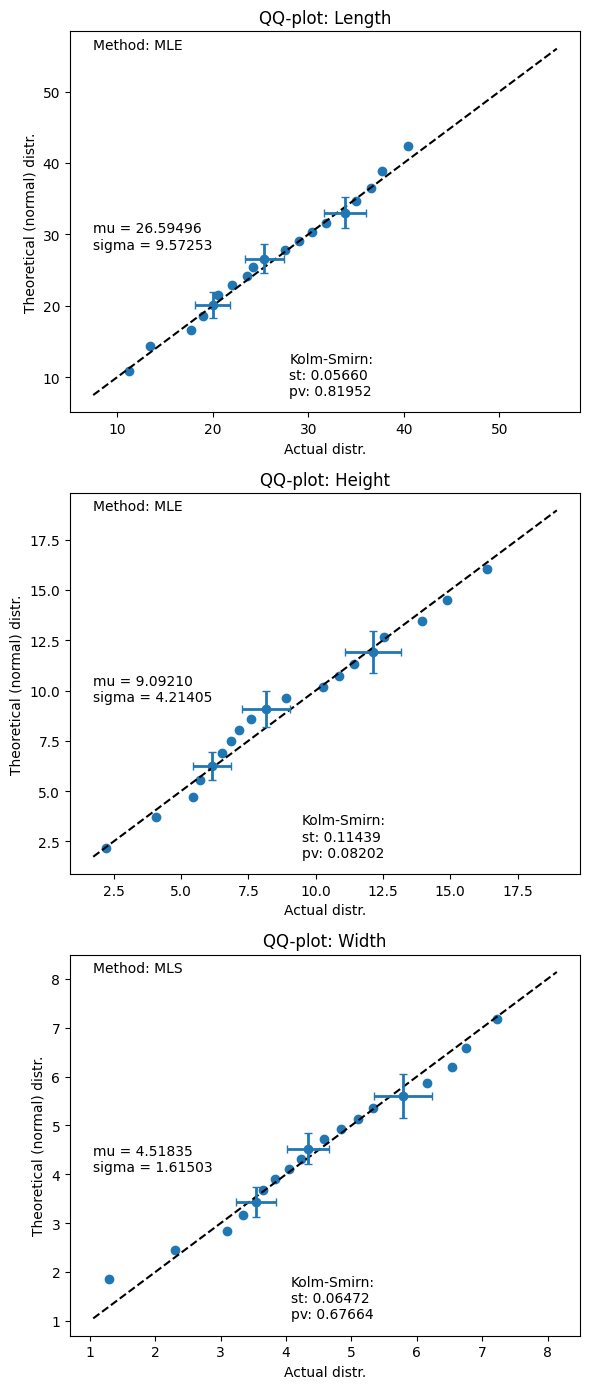

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(6,14))

percs = np.linspace(0, 100, 21) # percentiles

for n_row, dt in enumerate([data.Length, data.Height, data.Width]):
    qn_real_dist = np.percentile(dt, percs) # quantiles of the real values

    if n_row != 2:
        x, y, mu, sigma = plot_norm_MLE(dt, ax=None) # norm distribution values (MLE)
    else:
        x, y, mu, sigma = plot_norm_MLS(dt, ax=None, optimizer='TNC')

    title = ['Length', 'Height', 'Width']
    method = ['MLE', 'MLE', 'MLS']
    params = (mu, sigma)


    # Quantiles of the assumed dist
    qn_norm_dist = stats.norm.ppf(percs / 100.0, *params)

    # QQ-plot
    QQplot(dt, qn_real_dist, qn_norm_dist, params, axes[n_row],
           logN=False, title=title[n_row], method=method[n_row])

    # Calculating of the confidence intervals
    conf_real = conf_intervals(dt, qn_real_dist)
    conf_norm = conf_intervals(dt, qn_real_dist)
    print(f'{title[n_row]}:\n25%, 50%, 75% - confidence intervals for ACTUAL DISTRIBUTION:\n {conf_real}')
    print(f'25%, 50%, 75% - confidence intervals for THEORETICAL (normal) DISTRIBUTION:\n {conf_norm}\n')
    conf_real_list = []
    conf_norm_list = []
    for element1, element2 in zip(conf_real, conf_norm):
        conf_real_list.append(element1[0])
        conf_norm_list.append(element2[0])

    # Plotting the confidence intervals
    axes[n_row].errorbar(
        # [25%, 50%, 75%]
        [qn_real_dist[5], qn_real_dist[10], qn_real_dist[15]],
        [qn_norm_dist[5], qn_norm_dist[10], qn_norm_dist[15]],
        xerr=conf_real_list,
        yerr=conf_norm_list,
        ls='none',
        capsize=3,
        elinewidth=2
    )

plt.tight_layout()



---



---



Теперь перейдем к построению ***QQ-plot*** для случайной величины ***Weight***:

<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: divide by zero encountered in divide
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: divide by zero encountered in log
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-24-91b7a4c02137>:8: RuntimeWarning: invalid value encountered in multiply
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-37-0d768c792644>:20: RuntimeWarning: divide by zero encountered in divide
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-37-0d768c792644>:20: RuntimeWarning: divide by zero encountered in log
  y = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
<ipython-input-37-0d768c792644>:20: RuntimeWarning: invalid value en

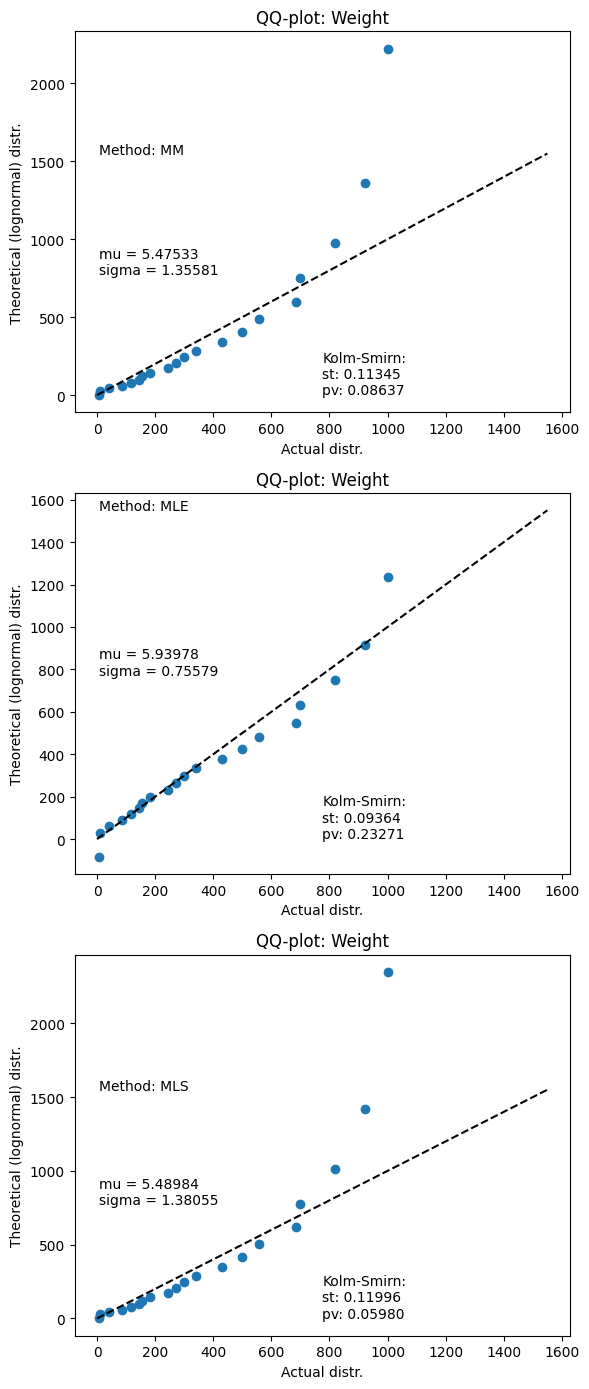

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(6,14))

dt = data.Weight # actual data
percs = np.linspace(0, 100, 21) # percentiles
qn_real_dist = np.percentile(dt, percs) # quantiles of the real values

x_MM, y_MM, mu_MM, sigma_MM = plot_logN_dist(dt, ax=None) # norm distribution values (MM)
x_MLE, y_MLE, shape_MLE, loc_MLE, scale_MLE = plot_logN_MLE(dt, ax=None) # norm distribution values (MLE)
x_MLS, y_MLS, mu_MLS, sigma_MLS = plot_logN_MLS(dt, ax=None) # norm distribution values (MLS)

def get_shape_loc_scale(mu, sigma):
    # Get params as (shape, loc, scale) from mu and sigma values for MM and MLS
    logsample = stats.norm.rvs(loc=mu, scale=sigma, size=1000) # logsample ~ N(mu, sigma)
    sample = np.exp(logsample) # sample ~ lognormal(mu, sigma)
    params = stats.lognorm.fit(sample) # fitting params
    return params

ys = [y_MM, y_MLE, y_MLS]
title = 'Weight'
method = ['MM', 'MLE', 'MLS']
params = [get_shape_loc_scale(mu_MM, sigma_MM),
          (shape_MLE, loc_MLE, scale_MLE),
          get_shape_loc_scale(mu_MLS, sigma_MLS)]

for n_row, y in enumerate(ys):
    # Quantiles of the assumed dist
    qn_lognorm_dist = stats.lognorm.ppf(percs / 100.0, *params[n_row])

    # QQ-plot
    QQplot(dt, qn_real_dist, qn_lognorm_dist, params[n_row], axes[n_row],
           logN=True, title=title, method=method[n_row])

plt.tight_layout()

На графиках изображены **квантильные биплоты** для случайной величины: ***Weight*** для каждого из трех методов параметрической оценки распределений (строки сетки графиков):

*   *Метод Моментов (MM)*;
*   *Метод Наибольшего Правдоподобия (MLE)*;
*   *МНК (MLS)*.

Из построенных квантильных биплотов для случайной величины, распределенной, как мы предположили, в соответствии с ***логнормальным*** распределением, видно, что большинство значений квантилей лежат на биссектриссе. Однако в случае с методом моментов (*MM*) и МНК (*MLS*) наблюдается сильное "задирание" хвоста графика кверху.
Метод максимального правдоподобия (*MLE*) же показал наилучшее приближение теор. распределения к данным среди прочих.

Для всех вариантов методов подбора параметров распределений были проведены статистические тесты ***Колмагорова-Смирнова***. В результате были получены значения **оцененной статистики** (*st*) и **pvalue** (*pv*).

Сравнив полученные статистические параметры можно сделать вывод, что в случае использования метода моментов (*MM*) и метода максимального правдоподобия (*MLE*) при оценке параметров теоретических распределений можно говорить, что распределение реальной исходой случайной величины **соответствует логнормальному распределению** *(**pvalue** > 0.05)*.

Причем по значениям оцененных статистик (***st***) можно определить, что для случайной величины *Weight* лучшие параметры распределения были подобраны при помощи метода максимального правдоподобия (***МLE***).


Ниже представлен QQ-plot для лучшего из подобранных распределений с **доверительными интервалами** для случайной величины ***Weight***:

Weight:
25%, 50%, 75% - confidence intervals for ACTUAL DISTRIBUTION:
 [array([48.02287766]), array([66.12722916]), array([107.29876837])]
25%, 50%, 75% - confidence intervals for THEORETICAL (lognormal) DISTRIBUTION:
 [array([48.02287766]), array([66.12722916]), array([107.29876837])]



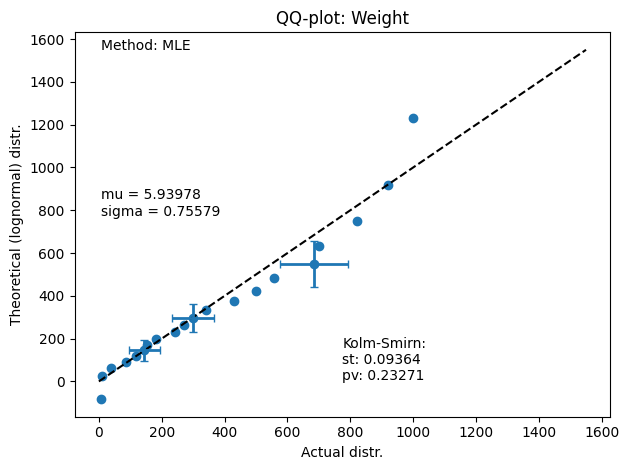

In [ ]:
axes = plt.subplot()

dt = data.Weight # actual data
percs = np.linspace(0, 100, 21) # percentiles
qn_real_dist = np.percentile(dt, percs) # quantiles of the real values
x, y, shape, loc, scale = plot_logN_MLE(dt, ax=None) # norm distribution values (MLE)

title = 'Weight'
method = 'MLE'
params = (shape, loc, scale)

# Quantiles of the assumed dist
qn_lognorm_dist = stats.lognorm.ppf(percs / 100.0, *params)

# QQ-plot
QQplot(dt, qn_real_dist, qn_lognorm_dist, params, axes,
       logN=True, title=title, method=method)

# Calculating of the confidence intervals
conf_real = conf_intervals(dt, qn_real_dist)
conf_lognorm = conf_intervals(dt, qn_real_dist)
print(f'{title}:\n25%, 50%, 75% - confidence intervals for ACTUAL DISTRIBUTION:\n {conf_real}')
print(f'25%, 50%, 75% - confidence intervals for THEORETICAL (lognormal) DISTRIBUTION:\n {conf_lognorm}\n')
conf_real_list = []
conf_lognorm_list = []
for element1, element2 in zip(conf_real, conf_lognorm):
    conf_real_list.append(element1[0])
    conf_lognorm_list.append(element2[0])

# Plotting the confidence intervals
axes.errorbar(
    # [25%, 50%, 75%]
    [qn_real_dist[5], qn_real_dist[10], qn_real_dist[15]],
    [qn_lognorm_dist[5], qn_lognorm_dist[10], qn_lognorm_dist[15]],
    xerr=conf_real_list,
    yerr=conf_lognorm_list,
    ls='none',
    capsize=3,
    elinewidth=2
)

plt.tight_layout()

#### Дискретная случайная величина

In [ ]:
def QQplot_discrete(dt, qn_first, qn_second, params, ax, title='QQ-plot', method='method'):
    mu = params[0]
    x = range(7)
    ylabel = 'poisson'

    # Bissectriss
    ax.plot(x, x, color="k", ls="--")

    # QQ-plot
    ax.scatter(qn_first, qn_second)
    ax.set_xlabel('Actual distr.')
    ax.set_ylabel(f'Theoretical ({ylabel}) distr.')
    ax.set_title(f'QQ-plot: {title}')
    ax.annotate(f"Method: {method}", xy=(dt.min(), dt.max()))

    # Calculation of the Kolmogorov-Smirnov test and chi-square
    # ks = stats.kstest(dt, 'poisson', params, N=len(dt))
    # ax.annotate(f"Kolm-Smirn:\nst: {ks[0]:.5f}\npv: {ks[1]:.5f}",
    #                             xy=(0.5*dt.max(), dt.min()))
    ax.annotate(f"mu = {mu:.5f}", xy=(0, 0.7*dt.max()))

Species:
25%, 50%, 75% - confidence intervals for ACTUAL DISTRIBUTION:
 [array([0.4136474]), array([0.27279139]), array([0.51693252])]
25%, 50%, 75% - confidence intervals for THEORETICAL (lognormal) DISTRIBUTION:
 [array([0.4136474]), array([0.27279139]), array([0.51693252])]



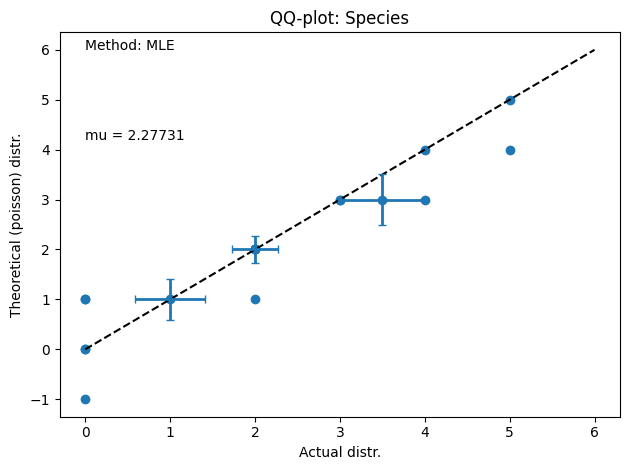

In [ ]:
axes = plt.subplot()

dt = data.Species # actual data
percs = np.linspace(0, 100, 21) # percentiles
qn_real_dist = np.percentile(dt, percs) # quantiles of the real values
x, y, mle_params = plot_poisson_MLE(dt, ax=None) # poisson distribution values (MLE)

title = 'Species'
method = 'MLE'
params = mle_params

# Quantiles of the assumed dist
qn_poisson_dist = stats.poisson.ppf(percs / 100.0, *params)

# QQ-plot
QQplot_discrete(dt, qn_real_dist, qn_poisson_dist, params, axes,
                title=title, method=method)

# Calculating of the confidence intervals
conf_real = conf_intervals(dt, qn_real_dist)
conf_poisson = conf_intervals(dt, qn_real_dist)
print(f'{title}:\n25%, 50%, 75% - confidence intervals for ACTUAL DISTRIBUTION:\n {conf_real}')
print(f'25%, 50%, 75% - confidence intervals for THEORETICAL (lognormal) DISTRIBUTION:\n {conf_poisson}\n')
conf_real_list = []
conf_poisson_list = []
for element1, element2 in zip(conf_real, conf_poisson):
    conf_real_list.append(element1[0])
    conf_poisson_list.append(element2[0])

# Plotting the confidence intervals
axes.errorbar(
    # [25%, 50%, 75%]
    [qn_real_dist[5], qn_real_dist[10], qn_real_dist[15]],
    [qn_poisson_dist[5], qn_poisson_dist[10], qn_poisson_dist[15]],
    xerr=conf_real_list,
    yerr=conf_poisson_list,
    ls='none',
    capsize=3,
    elinewidth=2
)

plt.tight_layout()

## 7 Оценка достоверности подогнанных распределений

### Непрерывные случайные величины

Помимо уже реализованной в предыдущем пункте проверки на однородность подогнанных распределений с реальными данными при помощи ***теста Колмогорова-Смирнова***, воспользуемся еще некоторыми статистическими тестами.

В конце сведем полученные результаты в таблицу.

#### Критерий Стьюдента (для нормальных распределений)

Попробуем использовать критерий Стьюдента для нормальных распределений.

Для этого сначала нам нужно проверить нормальность распределения средних в выборке. Для этого мы можем использовать тест Шапиро — Уилка.

Далее нам нужно узнать, равны ли дисперсии выборок. Для этого используем критерий Левене.

##### Критерий Шапиро-Уилка и Левене

Критерий Шапиро-Уилка

> **H0:** средние выборок распределены нормально.

Критерий Левене:

> **H0:** дисперсии двух выборок равны.

In [ ]:
def shapiro_wilka_levene(actual, theor):
    actual_dist = np.histogram(actual, bins=119, density=True)[0]
    bootsrtap_dist = stats.bootstrap([actual,], np.mean, n_resamples=55, random_state=42).bootstrap_distribution
    print(shapiro(bootsrtap_dist))
    print(levene(actual_dist, theor),end='\n\n')

In [ ]:
for label in ['Length', 'Height', 'Width']:
    if i < 2:
        x, y, mu, sigma = plot_norm_MLE(data[label], ax=None) # norm distribution values (MLE)
    elif i == 2:
        x, y, mu, sigma = plot_norm_MLS(data[label], ax=None, optimizer='TNC') # norm distribution values (MLS)
    print(label,':')
    shapiro_wilka_levene(data[label], y)

Length :
ShapiroResult(statistic=0.9835938215255737, pvalue=0.6533780097961426)
LeveneResult(statistic=13.62146139632098, pvalue=0.0002777229148174328)

Height :
ShapiroResult(statistic=0.9864248633384705, pvalue=0.7883434891700745)
LeveneResult(statistic=25.492879167002044, pvalue=8.879451325622922e-07)

Width :
ShapiroResult(statistic=0.9916468262672424, pvalue=0.9672688245773315)
LeveneResult(statistic=21.781054305241323, pvalue=5.124913760358032e-06)



Интерпретируем результаты:

Высокие значения критерия Шапиро-Уилка во всех трех случаях говорят о принятии нулевой гипотезы, то есть мы можем утверждать, что **средние** этих выборок **распределены нормально**.

По значениям критерия Левене же во всех трех случаях можно судить, что мы **не можем подтвердить** гипотезу о **равенстве дисперсий**. Учтем это при т-тесте.

##### t-тест

По статистическому **критерию Стьюдента** выдвигается **Н0**:

> H0: «Средние двух выборок принадлежат одной и той же генеральной совокупности».

Критерий применим к нормальным распределениям.

In [ ]:
for i, label in enumerate(['Length', 'Height', 'Width']):
    if i < 2:
        x, y, mu, sigma = plot_norm_MLE(data[label], ax=None) # norm distribution values (MLE)
    elif i == 2:
        x, y, mu, sigma = plot_norm_MLS(data[label], ax=None, optimizer='TNC') # norm distribution values (MLS)
    else:
        x, y, shape, loc, scale = plot_logN_MLE(data[label], ax=None) # lognorm distribution values (MLE)

    res = stats.ttest_ind(np.histogram(data[label], bins=len(data), density=True)[0], y,
                          equal_var=False, trim=.05)
    print(f"T-test results for the {label}:")
    display(res)
    if res[1] > 0.05:
        print(f"Нулевая гипотеза принимается (pvalue={res[1]:.3f} > 0.05)\n")
    else:
        print(f"Нулевая гипотеза отвергается (pvalue={res[1]:.3f} < 0.05)\n")

T-test results for the Length:


TtestResult(statistic=0.3839835749948937, pvalue=0.7014549190456217, df=175.69531330233067)

Нулевая гипотеза принимается (pvalue=0.701 > 0.05)

T-test results for the Height:


TtestResult(statistic=2.07158629806521, pvalue=0.039846604955208156, df=166.46331012733907)

Нулевая гипотеза отвергается (pvalue=0.040 < 0.05)

T-test results for the Width:


TtestResult(statistic=1.4801852912555253, pvalue=0.14063325781487407, df=173.89442603516173)

Нулевая гипотеза принимается (pvalue=0.141 > 0.05)



Как видим для случайных величин *Length* и *Width* мы *принимаем* нулевую гипотезу о равенстве средних.

Для величины *Height* гипотеза *отверглась*.
Исходя из известной информации в доменной области величина должна быть распределена подобно нормальному распределению. Возможно попалась не самая характерная выборка для данной случайной величины либо просто недостаточно большая выборка анализируемых данных.



##### Эксперимент: примение смесей для *Height*

В рамках данной работы ради эксперемента попробуем применить смесь нормальных распределений, ведь если подробнее посмотреть на распределение данных в рассматриваемой выборке и провести еще раз непараметрическую оценку увеличив число бинов в гистрограмме, то можно обнаружить не один, а два, если даже не три пика:

<Axes: xlabel='Height', ylabel='Count'>

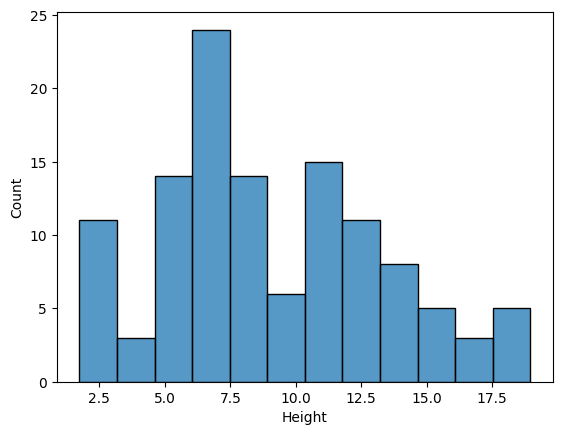

In [ ]:
sns.histplot(data.Height, bins=12)

Определим оптимальное число компоненты смеси:

In [ ]:
from sklearn.mixture import GaussianMixture
def component(data, columns, method):
    n = 1
    max_comp = 10
    x = []
    scores = []
    if data.shape[0] < max_comp:
        max_comp = data.shape[0]
    if len(columns) == 1:
        x = np.transpose([data[columns[0]].values])
    else:
        x = data[columns].values
    if method == "aic":
        lowest_aic = np.infty
        comp_lowest = 0
        for i in range(1, max_comp + 1, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0)
            gm1.fit(x)
            aic1 = gm1.aic(x)
            scores.append(aic1)
            if aic1 < lowest_aic:
                lowest_aic = aic1
                comp_lowest = i
            n = comp_lowest

    if method == "bic":
        lowest_bic = np.infty
        comp_lowest = 0
        for i in range(1, max_comp + 1, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0)
            gm1.fit(x)
            bic1 = gm1.bic(x)
            scores.append(bic1)
            if bic1 < lowest_bic:
                lowest_bic = bic1
                comp_lowest = i
            n = comp_lowest
    return n, scores

n, scores = component(data, ['Height'], 'bic')
n

3

Text(0, 0.5, '-LL')

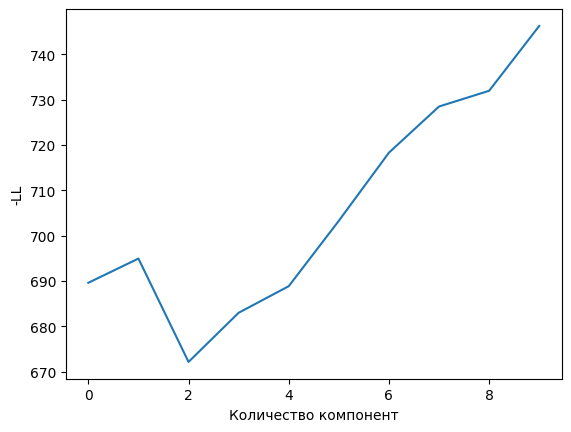

In [ ]:
plt.plot([i for i in range(len(scores))], scores)
plt.xlabel('Количество компонент')
plt.ylabel('-LL')

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=42).fit(data[['Height']].values)
gmm.means_

array([[ 2.16855515],
       [11.42732729],
       [ 6.68677877],
       [15.42488558]])

In [ ]:
gmm.covariances_

array([[[0.06755707]],

       [[1.4065209 ]],

       [[1.52965184]],

       [[4.41683118]]])

In [ ]:
gmm.weights_

array([0.09038893, 0.25267348, 0.47201154, 0.18492605])

In [ ]:
data['Height_comp'] = gmm.predict(data[['Height']].values)
# samples0 = data.loc[data['Height_comp'] == 0]['Height'].values
samples1 = data.loc[data['Height_comp'] == 1]['Height'].values
samples2 = data.loc[data['Height_comp'] == 2]['Height'].values
samples3 = data.loc[data['Height_comp'] == 3]['Height'].values

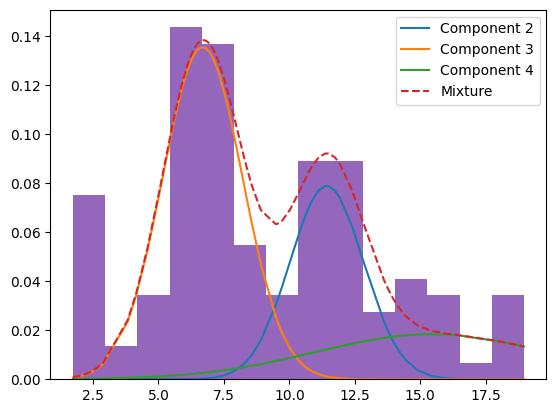

In [ ]:
# define your distributions
# d1 = stats.norm(gmm.means_[0][0], gmm.covariances_[0][0])
d2 = stats.norm(gmm.means_[1][0], gmm.covariances_[1][0])
d3 = stats.norm(gmm.means_[2][0], gmm.covariances_[2][0])
d4 = stats.norm(gmm.means_[3][0], gmm.covariances_[3][0])

# set mixture component weights
mc = [gmm.weights_[1], gmm.weights_[2], gmm.weights_[3]]
mc = mc / np.sum(mc) # ensuring they sum to 1

# where to evaluate the densities
x = sorted(data['Height'].values)
# calculate density and apply mixture weights
# c1 = d1.pdf(x) * mc[0]
c2 = d2.pdf(x) * mc[0]
c3 = d3.pdf(x) * mc[1]
c4 = d4.pdf(x) * mc[2]

# plot everything
# plt.plot(x, c1, label='Component 1')
plt.plot(x, c2, label='Component 2')
plt.plot(x, c3, label='Component 3')
plt.plot(x, c4, label='Component 4')
plt.plot(x, c2 + c3 + c4, '--', label='Mixture')
plt.hist(data['Height'].values, bins=14, density=True)
plt.legend()

Немного поигравшись с количеством компонент, выбор сделан в пользу трех и итоговый график распределения плотности вероятности для смеси Гауссовых распределений, описывающих выборку *Height* выглядит следующим образом:

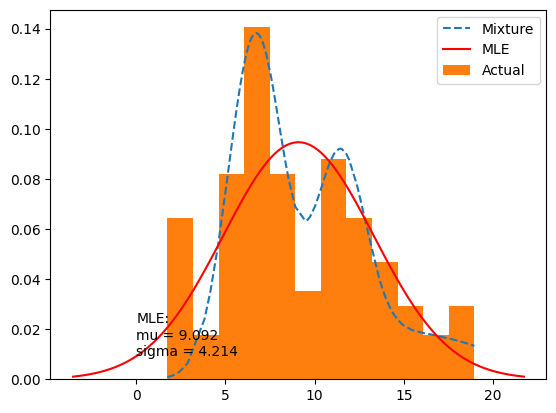

In [ ]:
x = sorted(data['Height'].values)
y_mixture = c2 + c3 + c4
plt.plot(x, y_mixture, '--', label='Mixture')
_,_,_,_ = plot_norm_MLE(data['Height'], ax=plt, label='MLE')
plt.hist(data['Height'].values, bins=12, density=True, label='Actual')
plt.legend()

Еще раз проведем тест Колмогорова-Смирнова для оценки распределения смеси:

In [ ]:
label = 'Height'
print(f"Kolmogorov-Smirnov test results for the {label}:")
actual_dist = np.histogram(data[label], bins=12, density=True)[0]
print(stats.kstest(y_mixture, actual_dist), end='\n\n')

Kolmogorov-Smirnov test results for the Height:
KstestResult(statistic=0.36204481792717086, pvalue=0.08890167182024276, statistic_location=0.08784919689728356, statistic_sign=-1)



Тест Колмогорова-Смирнова дал чуть большее значение pvalue, но сильно увеличилось значение самой статистики (максимальная разница между значениями распределений), что нехорошо. Причиной этому скорее всего является тот факт, что мы упускаем большой объем элементов выборки, значения которых лежат в районе 2-2.5 (как видно из гистограммы). Мы, конечно, можем покрыть и этот пик распределения, добавив к смеси еще одну компоненту, но тогда модель смеси будет еще более переобученной, ведь реальное распределение, исходя из доменных значений, при увеличении числа элементов выборки должно стремиться к нормальному.

#### U-критерий Манна — Уитни (для нормальных распределений)

Альтернативный тест — U-критерий Манна — Уитни, который сравнивает медиану двух распределений. В частности, нулевая гипотеза для этого теста состоит в том, что:

> **H0:** две группы имеют одинаковое распределение,

тогда как альтернативная гипотеза — в том, что:

> **H1:** одна группа имеет большие (или меньшие) значения, чем другая.

Применяется для нормальных распределений.

In [ ]:
for i, label in enumerate(['Length', 'Height', 'Width']):
    if i < 2:
        x, y, mu, sigma = plot_norm_MLE(data[label], ax=None) # norm distribution values (MLE)
    elif i == 2:
        x, y, mu, sigma = plot_norm_MLS(data[label], ax=None, optimizer='TNC') # norm distribution values (MLS)
    else:
        x, y, shape, loc, scale = plot_logN_MLE(data[label], ax=None) # lognorm distribution values (MLE)

    actual_dist = np.histogram(data[label], bins=len(data[label]), density=True)[0]
    print(f"U-kriteria Mann-Whitnwey results for the {label}:")
    print(stats.mannwhitneyu(actual_dist, y), end='\n\n')

U-kriteria Mann-Whitnwey results for the Length:
MannwhitneyuResult(statistic=5809.0, pvalue=0.01593531008739282)

U-kriteria Mann-Whitnwey results for the Height:
MannwhitneyuResult(statistic=6567.0, pvalue=0.33128217998720266)

U-kriteria Mann-Whitnwey results for the Width:
MannwhitneyuResult(statistic=6382.0, pvalue=0.18599205419377096)



Для *Height* и *Width* мы получаем p-значение > 0,05, что означает, что мы не отвергаем нулевую гипотезу об отсутствии различий в медианах между теоретическими и реальными распределениями.

Для *Length* pvalue оказалось мало, это означает, что мы отвергаем нулевую гипотезу и не можем сказать, что различий в медианах между теоретическими и реальными распределениями нет.


#### Метод Монте-Карло (обобщенная проверка принадлежности распределению)

При оценке методом Монте-Карло нулевая гипотеза имеет вид
> **H0:** данные были взяты из распределения в этом семействе.

In [ ]:
for i, label in enumerate(['Length', 'Height', 'Width', 'Weight']):
    if i < 2:
        x, y, mu, sigma = plot_norm_MLE(data[label], ax=None) # norm distribution values (MLE)
        params = {'loc': mu, 'scale': sigma}
        distribution = stats.norm
    elif i == 2:
        x, y, mu, sigma = plot_norm_MLS(data[label], ax=None, optimizer='TNC') # norm distribution values (MLS)
        params = {'loc': mu, 'scale': sigma}
        distribution = stats.norm
    else:
        x, y, shape, loc, scale = plot_logN_MLE(data[label], ax=None) # lognorm distribution values (MLE)
        params = {'loc': loc, 'scale': scale, 's': shape}
        distribution = stats.lognorm

    print(f"Monte-Carlo method results for the {label}:")
    print(goodness_of_fit(distribution, data[label], statistic='cvm', known_params=params), end='\n\n')

Monte-Carlo method results for the Length:
GoodnessOfFitResult(fit_result=  params: FitParams(loc=26.59495798319328, scale=9.572525888656081)
 success: True
 message: 'The fit was performed successfully.', statistic=0.057491190456092654, pvalue=0.8341, null_distribution=array([0.06872568, 0.17580105, 0.04334408, ..., 0.14117409, 0.18449533,
       0.08942336]))

Monte-Carlo method results for the Height:
GoodnessOfFitResult(fit_result=  params: FitParams(loc=9.092095798319328, scale=4.214047416235948)
 success: True
 message: 'The fit was performed successfully.', statistic=0.22356961727272023, pvalue=0.2289, null_distribution=array([0.04478464, 0.1631913 , 0.0543219 , ..., 0.13546041, 0.04555637,
       0.0580207 ]))

Monte-Carlo method results for the Width:
GoodnessOfFitResult(fit_result=  params: FitParams(loc=4.518345678706787, scale=1.6150286987973534)
 success: True
 message: 'The fit was performed successfully.', statistic=0.09544021452948041, pvalue=0.6138, null_distribution=a

Для *Length*, *Height*, *Width* и *Weight* мы получаем p-value > 0,05, что означает, что мы **не отвергаем** нулевую гипотезу и считаем что данные принадлежат семействам своих теоретических распределений.

#### Тест Андерсона-Дарлинга

При оценке тестом Андерсона-Дарлинга нулевая гипотеза имеет вид
> **H0:** данные были взяты из распределения в этом семействе.

In [ ]:
for i, label in enumerate(['Length', 'Height', 'Width']):
    if i < 2:
        x, y, mu, sigma = plot_norm_MLE(data[label], ax=None) # norm distribution values (MLE)
    elif i == 2:
        x, y, mu, sigma = plot_norm_MLS(data[label], ax=None, optimizer='TNC') # norm distribution values (MLS)
    else:
        x, y, shape, loc, scale = plot_logN_MLE(data[label], ax=None) # lognorm distribution values (MLE)

    actual_dist = np.histogram(data[label], bins=len(data[label]), density=True)[0]
    print(f"Anderson-Darling test results for the {label}:")
    print(stats.anderson(data[label], 'norm'), end='\n\n')

Anderson-Darling test results for the Length:
AndersonResult(statistic=0.3907317033830111, critical_values=array([0.558, 0.636, 0.763, 0.89 , 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=26.59495798319328, scale=9.613001865759779)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Anderson-Darling test results for the Height:
AndersonResult(statistic=1.1955895713287106, critical_values=array([0.558, 0.636, 0.763, 0.89 , 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=9.092095798319328, scale=4.231865878021002)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Anderson-Darling test results for the Width:
AndersonResult(statistic=0.6966952181734456, critical_values=array([0.558, 0.636, 0.763, 0.89 , 1.058]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=4.50740

Для *Length* и *Width* мы получаем статистику не превышающую критическое значение на уровне значимости 5%, что означает, что мы **не отвергаем** нулевую гипотезу, и считаем, что данные взяты из теоретических распределений.

Для *Height* статистика превысила критическое значение, это означает, что мы **отвергаем** нулевую гипотезу и не можем сказать, что данные взяты из теоретического распределения.

### Дискретная случайная величина

#### Хи-квадрат критерий

При оценке Хи-квадрат критерием нулевая гипотеза имеет вид
> **H0:** категориальные данные имеют заданные частоты.

In [ ]:
f_obs = (data['Species'].value_counts().sort_index() / len(data['Species'])).to_list()
x, y_mle, mle_params = plot_poisson_MLE(data['Species'], ax=None)
try:
    chi = stats.chisquare(f_obs, y_mle)
    print(chi)
except:
    print("EXCEPTION WARNING!\n\nValueError: For each axis slice, the sum of the observed frequencies must agree with the sum\nof the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:\n0.008982672022554143")


EXCEPTION WARNING!

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum
of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.008982672022554143


При оценке распределения по Хи-квадрат критерию процентные различия сумм наблюдаемых и ожидаемых частот превышают относительный допуск 1e-08.

#### Тест Колмогорова-Смирнова

Тест Колмогорова-Смирнова показывает на сколько хорошо подходит теоретическое распределение данным.

In [ ]:
x,y,mle_params = plot_poisson_MLE(data['Species'], ax=None)
actual = np.histogram(data['Species'], bins=7, density=True)[0]

kstest = stats.kstest(actual, y, method='asymp')
print(kstest)

KstestResult(statistic=0.1428571428571429, pvalue=0.9999609537692629, statistic_location=0.14705882352941177, statistic_sign=1)


Тест показал высокое значение pvalue, что говорит о том, что распределение хорошо описывает реальные данные.

#### Таблица результатов тестов

Результаты всех проведенных тестов сведены в общую таблицу:

||Колмогоров-Смирнов|Монте-Карло|Андерсон-Дарлинг|Стьюдент|Манн-Уитни|Хи-квадрат|
|------------|-----|-----|-----|     |     |    |
| **Length** | да  | да  | да  | да  | нет |  - |
| **Height** | да  | да  |нет  | нет | да  |  - |
| **Width**  | да  | да  | да  | да  | да  |  - |
| **Weight** | да  | да  | -   |  -  |  -  |  - |
| **Species**| да  | -   | -   |  -  |  -  | нет|

## 8 Семплирование

#### Метод обратного преобразования

##### Непрерывные случайные величины

In [ ]:
def sample_reverse(dt, params, lognorm=False, ax=None):
    quantiles = np.random.uniform(0, 1, 1000)
    if lognorm:
        x = stats.lognorm.ppf(quantiles, *params)
    else:
        x = stats.norm.ppf(quantiles, *params)

    ax.hist(x, label='Sampled', density=True, alpha=0.4, bins='auto')
    ax.hist(dt, label='Actual', density=True, alpha=0.4, bins='auto')
    ax.plot()
    ax.legend()
    ax.set_xlim(0, dt.max()*1.2)

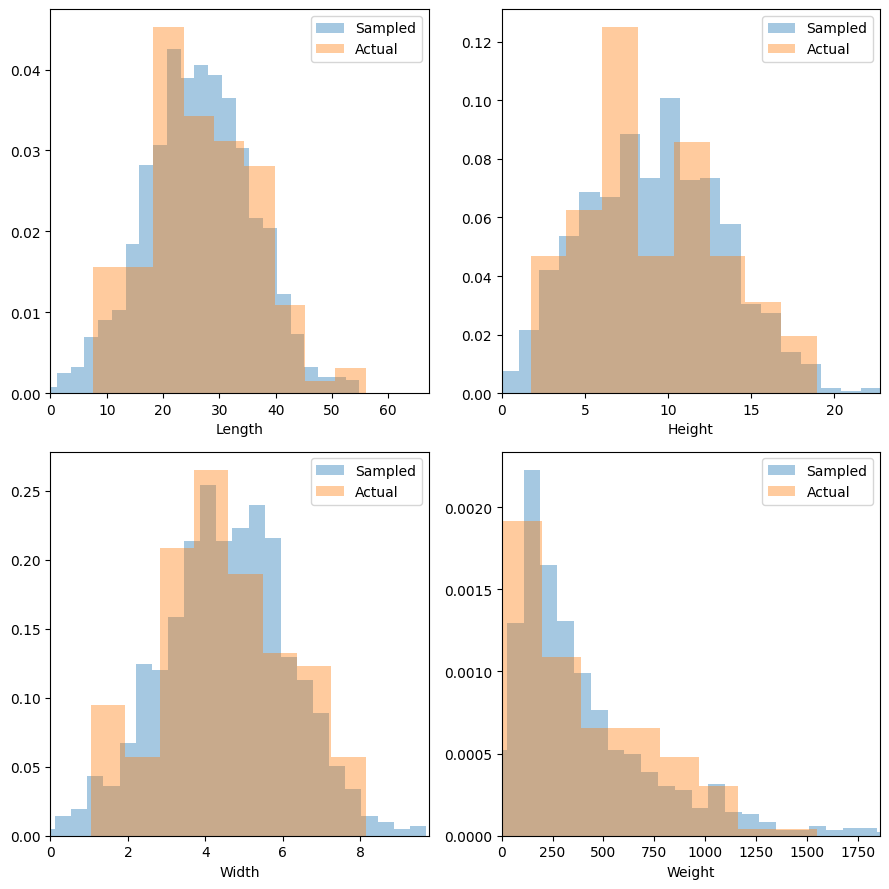

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))

for i, label in enumerate(['Length', 'Height', 'Width', 'Weight']):
    if i < 2:
        x, y, mu, sigma = plot_norm_MLE(data[label], ax=None) # norm distribution values (MLE)
        params = (mu, sigma)
        lognorm=False
    elif i == 2:
        x, y, mu, sigma = plot_norm_MLS(data[label], ax=None, optimizer='TNC') # norm distribution values (MLS)
        params = (mu, sigma)
        lognorm=False
    else:
        x, y, shape, loc, scale = plot_logN_MLE(data[label], ax=None) # lognorm distribution values (MLE)
        params = (shape, loc, scale)
        lognorm=True

    sample_reverse(data[label], params, ax=ax[i//2, i%2], lognorm=lognorm)
    ax[i//2, i%2].set_xlabel(label)
plt.tight_layout()

Были сгенерированы выборки, визуально похожие на теоретические распределения непрерывных случайных величин *Length*, *Height*, *Width* и *Weight*.

##### Дискретная случайная величина

In [ ]:
def sample_reverse_discrete(dt, params, lognorm=False, ax=None):
    quantiles = np.random.uniform(0, 1, 1000)
    x = stats.poisson.ppf(quantiles, *params)

    ax.hist(x, label='Sampled', density=True, alpha=0.4, bins=7)
    ax.hist(dt, label='Actual', density=True, alpha=0.4, bins=7)
    ax.plot()
    ax.legend()
    ax.set_xlim(0, dt.max()*1.2)

Text(0.5, 0, 'Species')

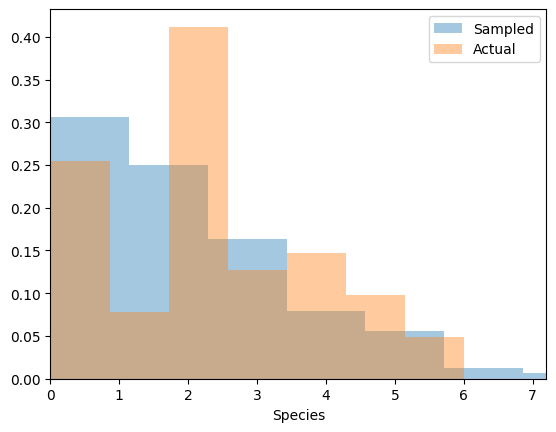

In [ ]:
ax = plt.subplot()

x, y, mle_params = plot_poisson_MLE(data['Species'], ax=None) # poisson distribution values (MLE)

sample_reverse_discrete(data['Species'], mle_params, ax=ax)
ax.set_xlabel('Species')

Была сгенерирована выборка, визуально похожая на теоретическое распределение дискретной случайной величины *Species*.

#### Выборка с отклонением

##### Непрерывные случайные величины

In [ ]:
def sample_cover(x, distr, params, N_const, params_cover, N_sample=100000, ax=None):
    '''
    x - значения исходной случайной величины
    distr - исходное распределение
    params - параметры исходного распределения
    N_const - нормирующая константа
    params_cover - параметры нормального накрывающего распределения
    N_sample - число семплируемых точек
    ax - для графиков
    '''
    samples = []
    for _ in range(N_sample):
        # get a candidate from normal distribution
        candidate = np.random.normal(*params_cover)

        # calculate probabailty of accepting this sample
        prob_accept = distr.pdf(
            candidate, *params) / (N_const * stats.norm.pdf(candidate, *params_cover))

        # accept sample with this probability
        if np.random.random() < prob_accept:
            samples.append(candidate)
    ax.hist(samples, bins=200, density=True)

Подберем подходящие значения нормирующих констант для накрывающих распределений

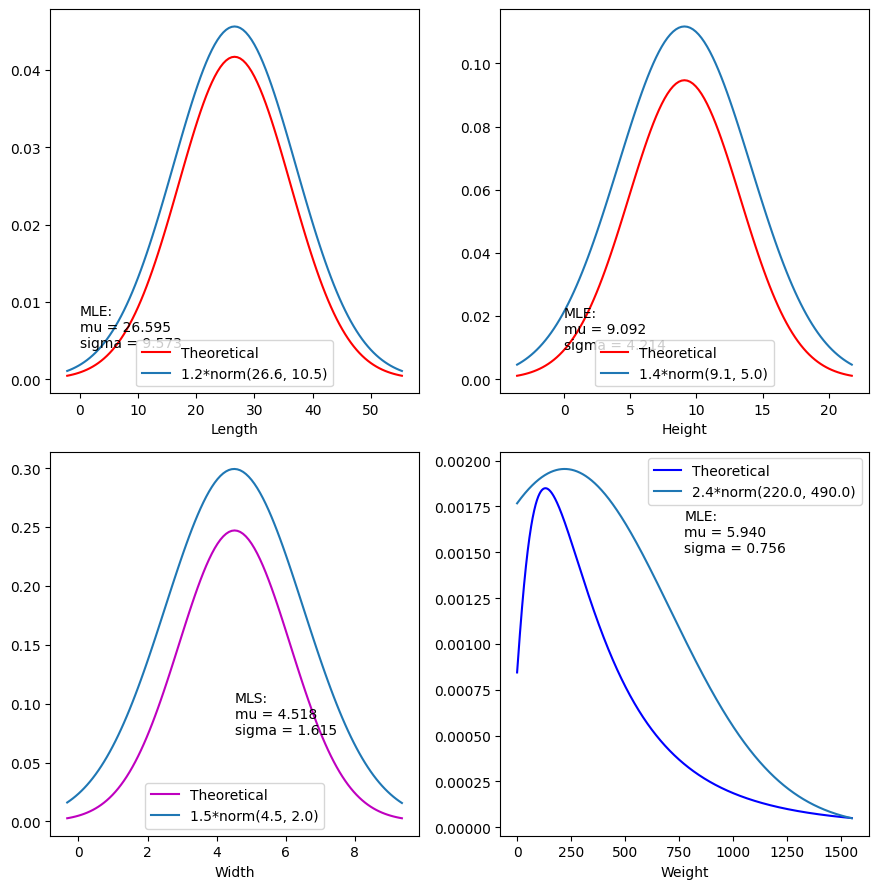

In [ ]:
# Параметры для накрыввающего нормального распределения
N_const = [1.2, 1.4, 1.5, 2.4]
params_cover = [[np.mean(data['Length']), 10.5], [np.mean(data['Height']), 5],\
          [np.mean(data['Width']), 2], [220, 490]]

fig, ax = plt.subplots(2,2, figsize=(9,9))
for i, label in enumerate(['Length', 'Height', 'Width', 'Weight']):
    if i < 2:
        x, y, mu, sigma = plot_norm_MLE(data[label], ax=ax[i//2, i%2],
                                        label='Theoretical') # norm distribution values (MLE)
    elif i == 2:
        x, y, mu, sigma = plot_norm_MLS(data[label], ax=ax[i//2, i%2],
                                        optimizer='TNC', label='Theoretical') # norm distribution values (MLS)
    else:
        x, y, shape, loc, scale = plot_logN_MLE(data[label], ax=ax[i//2, i%2],
                                                label='Theoretical') # lognorm distribution values (MLE)

    cover = N_const[i]*stats.norm.pdf(x, *params_cover[i])

    ax[i//2, i%2].plot(x, cover, label=f"{N_const[i]}*norm({params_cover[i][0]:.1f}, {params_cover[i][1]:.1f})")
    ax[i//2, i%2].set_xlabel(label)
    ax[i//2, i%2].legend()
    plt.tight_layout()

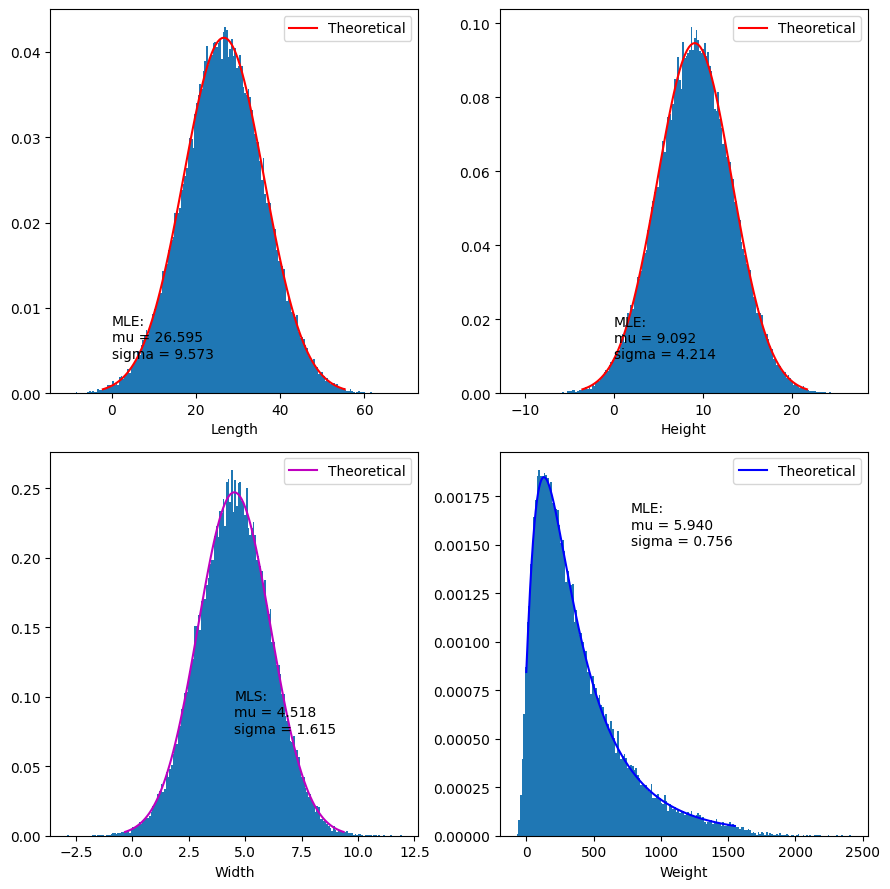

In [ ]:
# Параметры для накрыввающего нормального распределения
N_const = [1.2, 1.4, 1.5, 2.4]
params_cover = [[np.mean(data['Length']), 10.5], [np.mean(data['Height']), 5],\
          [np.mean(data['Width']), 2], [220, 490]]

fig, ax = plt.subplots(2,2, figsize=(9,9))
for i, label in enumerate(['Length', 'Height', 'Width', 'Weight']):
    if i < 2:
        x, y, mu, sigma = plot_norm_MLE(data[label], ax=ax[i//2, i%2],
                                        label='Theoretical') # norm distribution values (MLE)
        params = [mu, sigma]
        distr=stats.norm
    elif i == 2:
        x, y, mu, sigma = plot_norm_MLS(data[label], ax=ax[i//2, i%2],
                                        optimizer='TNC', label='Theoretical') # norm distribution values (MLS)
        params = [mu, sigma]
        distr=stats.norm
    else:
        x, y, shape, loc, scale = plot_logN_MLE(data[label], ax=ax[i//2, i%2],
                                                label='Theoretical') # lognorm distribution values (MLE)
        params = [shape, loc, scale]
        distr=stats.lognorm

    sample_cover(x, distr, params, N_const[i], params_cover[i], ax=ax[i//2, i%2])

    ax[i//2, i%2].set_xlabel(label)
    ax[i//2, i%2].legend()
    plt.tight_layout()

Было сгенерировано 100000 случайных величин, соответствующих теоретическим распределениям для непрерывных величин *Length*, *Height*, *Width* и *Weight*.

Метод сэмплирования выборкой отклонения позволяет генерировать случайные величины, которые визуально соответствуют ожидаемым распределениям, однако занимает большее время.

##### Дискретная случайная величина

Подберем параметры накрывающего нормального распределения и нормирующую константу

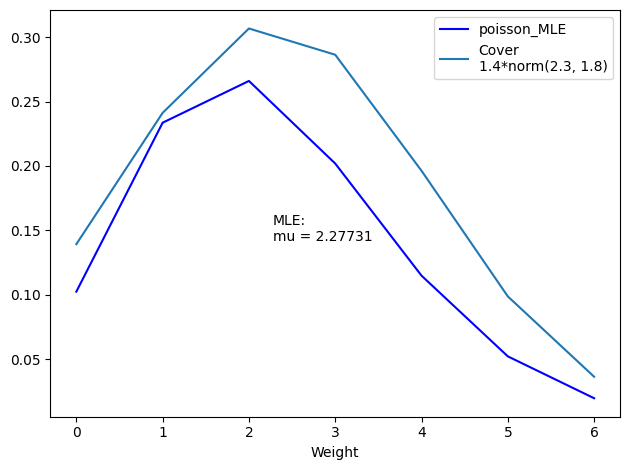

In [ ]:
# Параметры для накрывающего нормального распределения
N_const = 1.4
params_cover = [np.mean(data['Species']), 1.8]

ax = plt.subplot()

x,y_mle,mle_params = plot_poisson_MLE(data['Species'], ax=ax,
                                      label='poisson_MLE') # poisson distr (MLE)

cover = N_const * stats.norm.pdf(x, *params_cover) # cover normal distribution
ax.plot(x, cover,
        label=f"Cover\n{N_const}*norm({params_cover[0]:.1f}, {params_cover[1]:.1f})")

ax.set_xlabel(label)
ax.legend()
plt.tight_layout()

Перейдем к сэмплированию

In [ ]:
def sample_cover_poisson(x, params, N_const, params_cover, N_sample=1000, ax=None):
    '''
    x - значения исходной случайной величины
    params - параметры исходного распределения
    N_const - нормирующая константа
    params_cover - параметры нормального накрывающего распределения
    N_sample - число семплируемых точек
    ax - для графиков
    '''
    samples = []
    for _ in range(N_sample):
        # get a candidate from normal distribution
        candidate = np.random.poisson(params_cover[0])

        # calculate probabailty of accepting this sample
        prob_accept = stats.poisson.pmf(candidate, *params) / \
         (N_const * stats.norm.pdf(candidate, *params_cover))

        # accept sample with this probability
        if np.random.random() < prob_accept:
            samples.append(candidate)

    # ax.hist(samples, bins=200, density=True, label='Sampled')
    sns.histplot(samples, bins=200, stat='probability', ax=ax, label='Sampled')

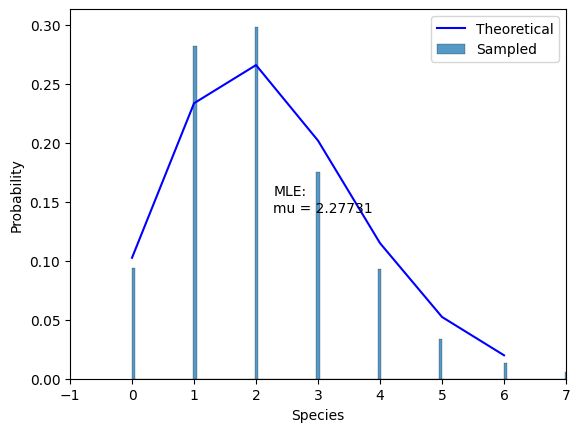

In [ ]:
# Параметры для накрыввающего нормального распределения
N_const = 1.4
params_cover = [np.mean(data['Species']), 1.8]

ax = plt.subplot()

x, y_mle, mle_params = plot_poisson_MLE(data['Species'], ax=ax,
                                     label='Theoretical') # poisson distribution values (MLE)

sample_cover_poisson(x, mle_params, N_const, params_cover, N_sample=10000, ax=ax)

ax.set_xlabel('Species')
ax.set_xlim(-1,7)
ax.legend()

Было сгенерировано 10000 случайных величин, соответствующих теоретическому распределению Пуассона для дискретной величины *Species*.

Метод сэмплирования выборкой отклонения позволяет генерировать случайные величины, которые визуально соответствуют ожидаемому распределению, однако данный метод занимает больше времени.